In [1]:
# =====================================================================
# 📦 Core Libraries
# =====================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import graphviz

from itertools import product
from collections import Counter
from datetime import datetime

# =====================================================================
# 📊 Data Preprocessing & Feature Selection
# =====================================================================
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

# =====================================================================
# 📐 Statistics & Diagnostics
# =====================================================================
from scipy.stats import (
    randint, kstest, norm, mannwhitneyu, ttest_ind, chi2_contingency
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# =====================================================================
# 🔍 Model Selection & Evaluation
# =====================================================================
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, RandomizedSearchCV,
    cross_val_predict, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, mean_squared_error, mean_absolute_error,
    cohen_kappa_score, matthews_corrcoef, roc_curve,
    precision_recall_curve, auc, make_scorer
)

# =====================================================================
# 🤖 Machine Learning Models
# =====================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# =====================================================================
# 🚀 Gradient Boosting Libraries
# =====================================================================
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# =====================================================================
# ⚖️ Imbalanced Data Handling
# =====================================================================
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline

# =====================================================================
# 💾 Persistence & Metadata
# =====================================================================
import joblib
import json

# =====================================================================
# 📍 Utilities
# =====================================================================
from kneed import KneeLocator


In [2]:
# =====================================================================
# 📂 Data Loading
# =====================================================================

# --- Load Training Data (skip first line: title row) ---
df = pd.read_csv("../data/lungCancer.csv", skiprows=1)

# --- Load Test Data ---
test_set = pd.read_csv("../data/test_set.csv", encoding="ISO-8859-1")

# --- Quick Checks: Shape & Column Headers ---
print("Training Set:", df.shape)
print("Columns:", df.columns.tolist())
print("\nTest Set:", test_set.shape)
print("Columns:", test_set.columns.tolist())


Training Set: (277, 58)
Columns: ['ID', 'Dataset', 'Diagnosis', 'Label', 'Predicted', 'Age', 'Sex', 'Smoking status', 'Cancer stage', 'White blood cell', 'Neutrophile granulocyte ratio', 'Lymphocyte ratio', 'Monocyte ratio', 'Eosinophil ratio', 'Basophil ratio', 'Neutrophilic granulocytes', 'Lymphocytes', 'Monocytes', 'Eosinophil cells', 'Basophil count', 'Red blood cell count', 'Hemoglobin', 'Hematocrit', 'Mean corpuscular volume', 'Mean corpuscular hemoglobin', 'Mean corpuscular hemoglobin concentration', 'Red blood cell distribution width - SD', 'Red blood cell distribution width - CV', 'Platelet', 'Platelet distribution width', 'Mean platelet volume', 'Large platelet ratio', 'Plateletcrit', 'Glucose', 'Carbamide', 'Creatinine', 'Carbamide/Creatinine', 'Uric acid', 'Alanine transaminase', 'Aspartate aminotransferase', 'AST/ALT', 'Glutamyl Transferase', 'Alkaline phosphatase\xa0', 'TotalProtein', 'Albumin', 'Globulin', 'ALB/GLB', 'Total bilirubin', 'Direct bilirubin', 'Indirect bilir

In [3]:
# =====================================================================
# 🧹 Data Cleaning & Preprocessing
# =====================================================================

# --- Drop unnecessary columns from Test Set ---
test_set.drop(columns=["ID", "Diagnosis", "'Cancer stage'"], inplace=True)

# --- Clean and standardize column names ---
test_set.columns = [
    col.replace("_", " ").strip().replace('"', "") for col in test_set.columns
]

# --- Rename specific columns for clarity ---
test_set.rename(
    columns={
        "Sex binarized": "Sex",
        "Smoking status binarized": "Smoking status",
        "ALB GLB ratio": "ALB/GLB",
    },
    inplace=True,
)

# --- Normalize labels in Test Set (-1 → 0, 1 → 1) ---
test_set["Label"] = test_set["Label"].replace({-1: 0, 1: 1})


# =====================================================================
# 🔄 Training & Validation Set Preparation
# =====================================================================

# --- Drop unnecessary columns ---
df.drop(columns=["ID", "Diagnosis", "Cancer stage", "Predicted"], inplace=True)

# --- Split into Training and Validation sets (based on 'Dataset' column) ---
training_set = df[df["Dataset"] == "Trainging set"].copy()
validation_set = df[df["Dataset"] == "Test set"].copy()

# --- Drop 'Dataset' column if no longer needed ---
training_set.drop(columns=["Dataset"], inplace=True)
validation_set.drop(columns=["Dataset"], inplace=True)


# =====================================================================
# 👤 Encode Categorical Variables
# =====================================================================

# --- Convert 'Sex' to binary (male=1, female=0) ---
training_set["Sex"] = training_set["Sex"].map({"male": 1, "female": 0})
validation_set["Sex"] = validation_set["Sex"].map({"male": 1, "female": 0})

# --- Convert 'Smoking status' to binary (Yes=1, No=0) ---
training_set["Smoking status"] = training_set["Smoking status"].map({"Yes": 1, "No": 0})
validation_set["Smoking status"] = validation_set["Smoking status"].map({"Yes": 1, "No": 0})

# --- Convert 'Label' to binary (1=True, 0=False) ---
print("Unique labels before conversion:", training_set["Label"].unique())
training_set["Label"] = (training_set["Label"] == 1).astype(int)
validation_set["Label"] = (validation_set["Label"] == 1).astype(int)
print("Label distribution after conversion:\n", training_set["Label"].value_counts(dropna=False))


# =====================================================================
# 🔍 Missing Values Check
# =====================================================================

# --- Count missing values per column in Training Set ---
missing_counts = training_set.isnull().sum()

# --- Keep only columns with missing values ---
missing_columns = missing_counts[missing_counts > 0]

# --- Display missing values summary ---
print("Missing values in training set:\n", missing_columns)



Unique labels before conversion: [ 1 -1]
Label distribution after conversion:
 Label
1    153
0     73
Name: count, dtype: int64
Missing values in training set:
 Series([], dtype: int64)


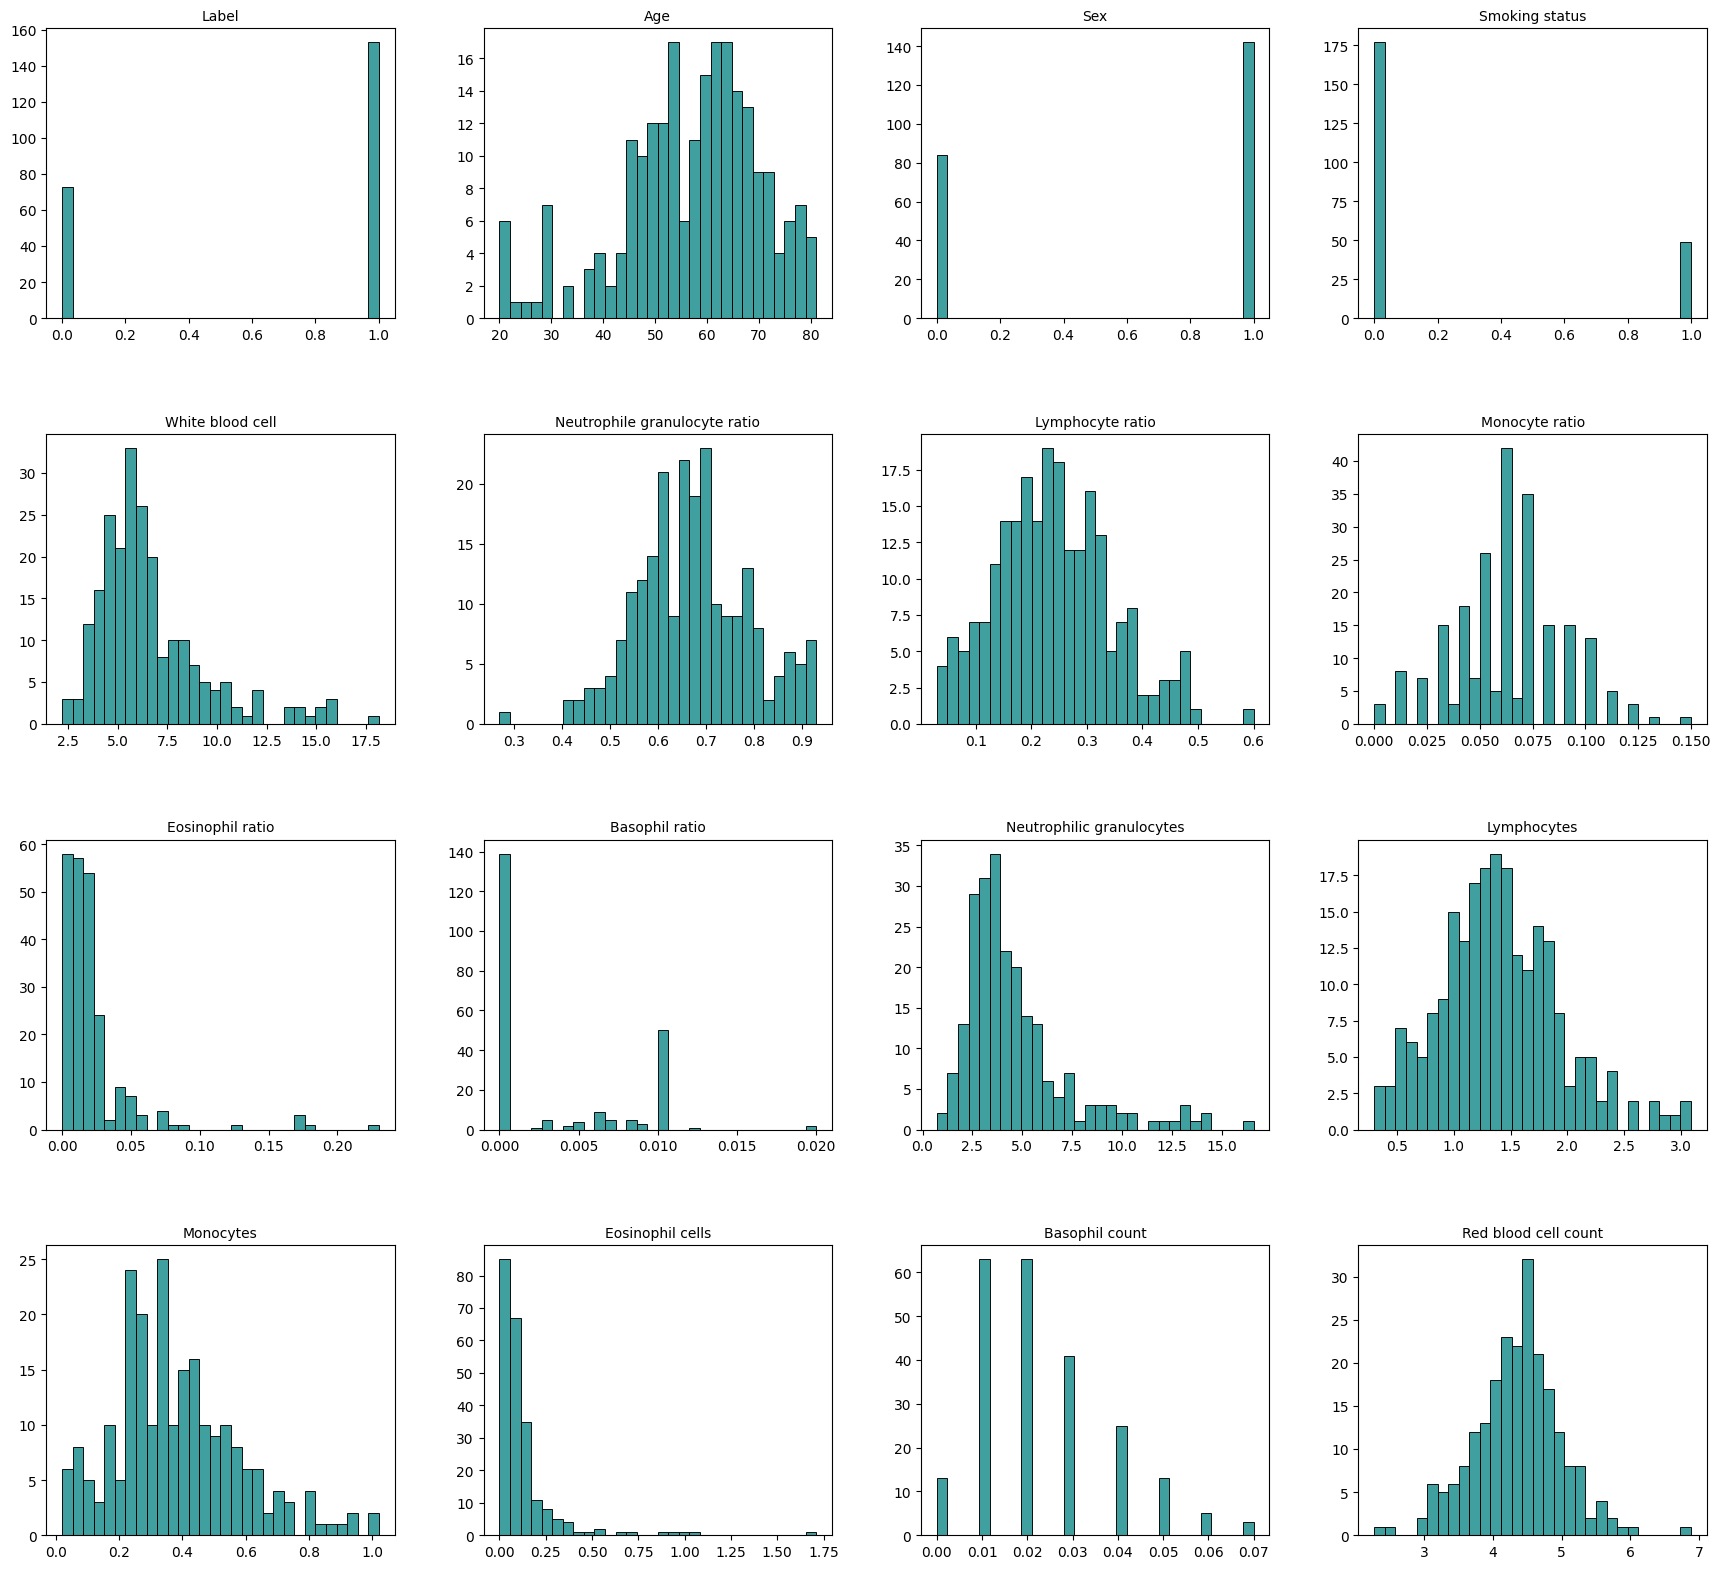

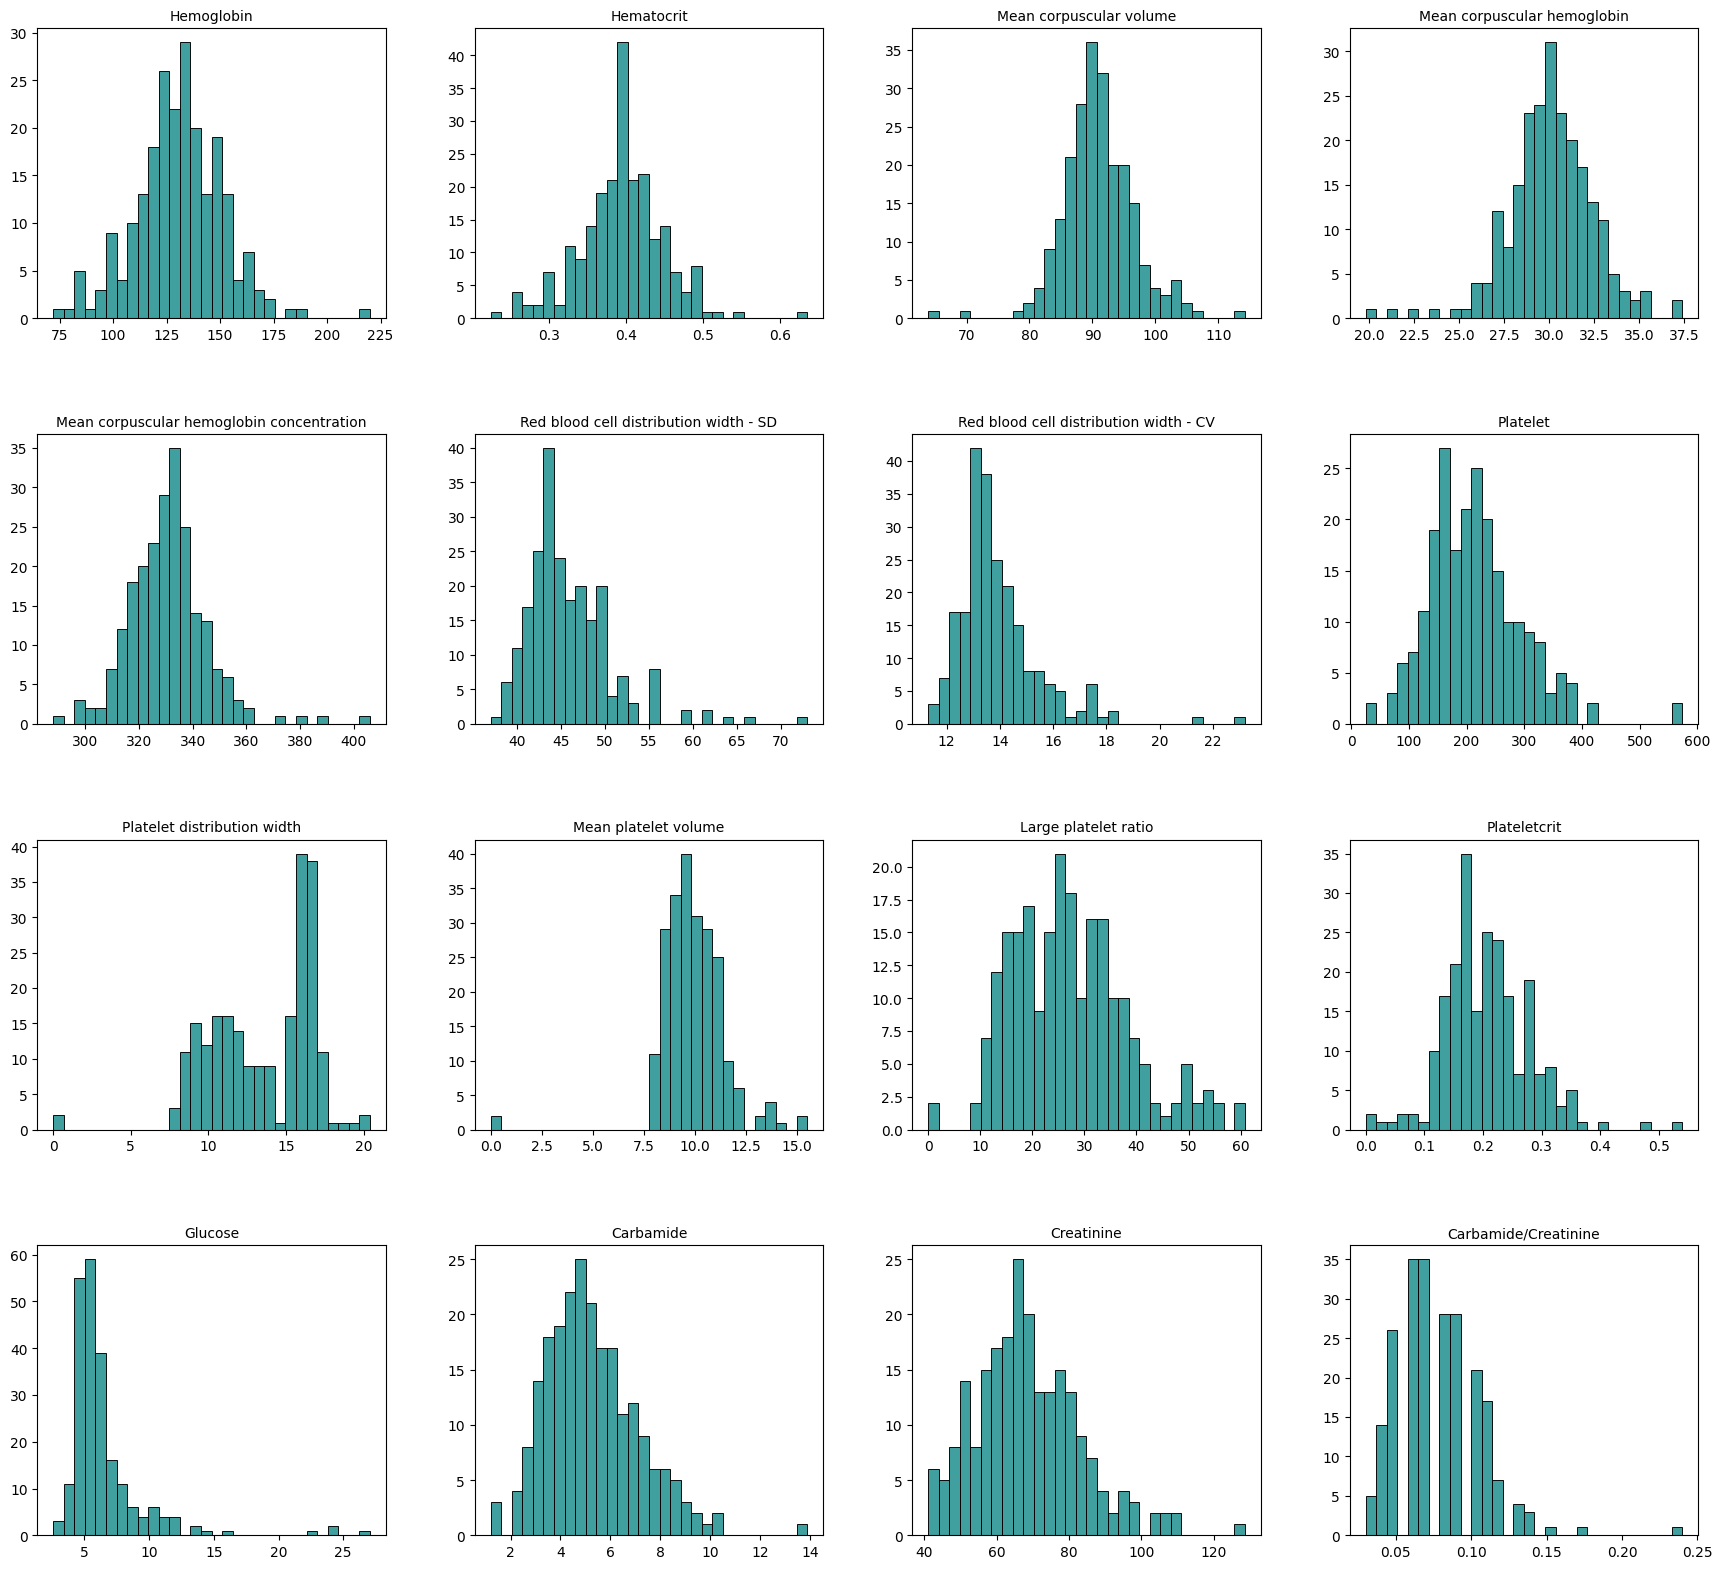

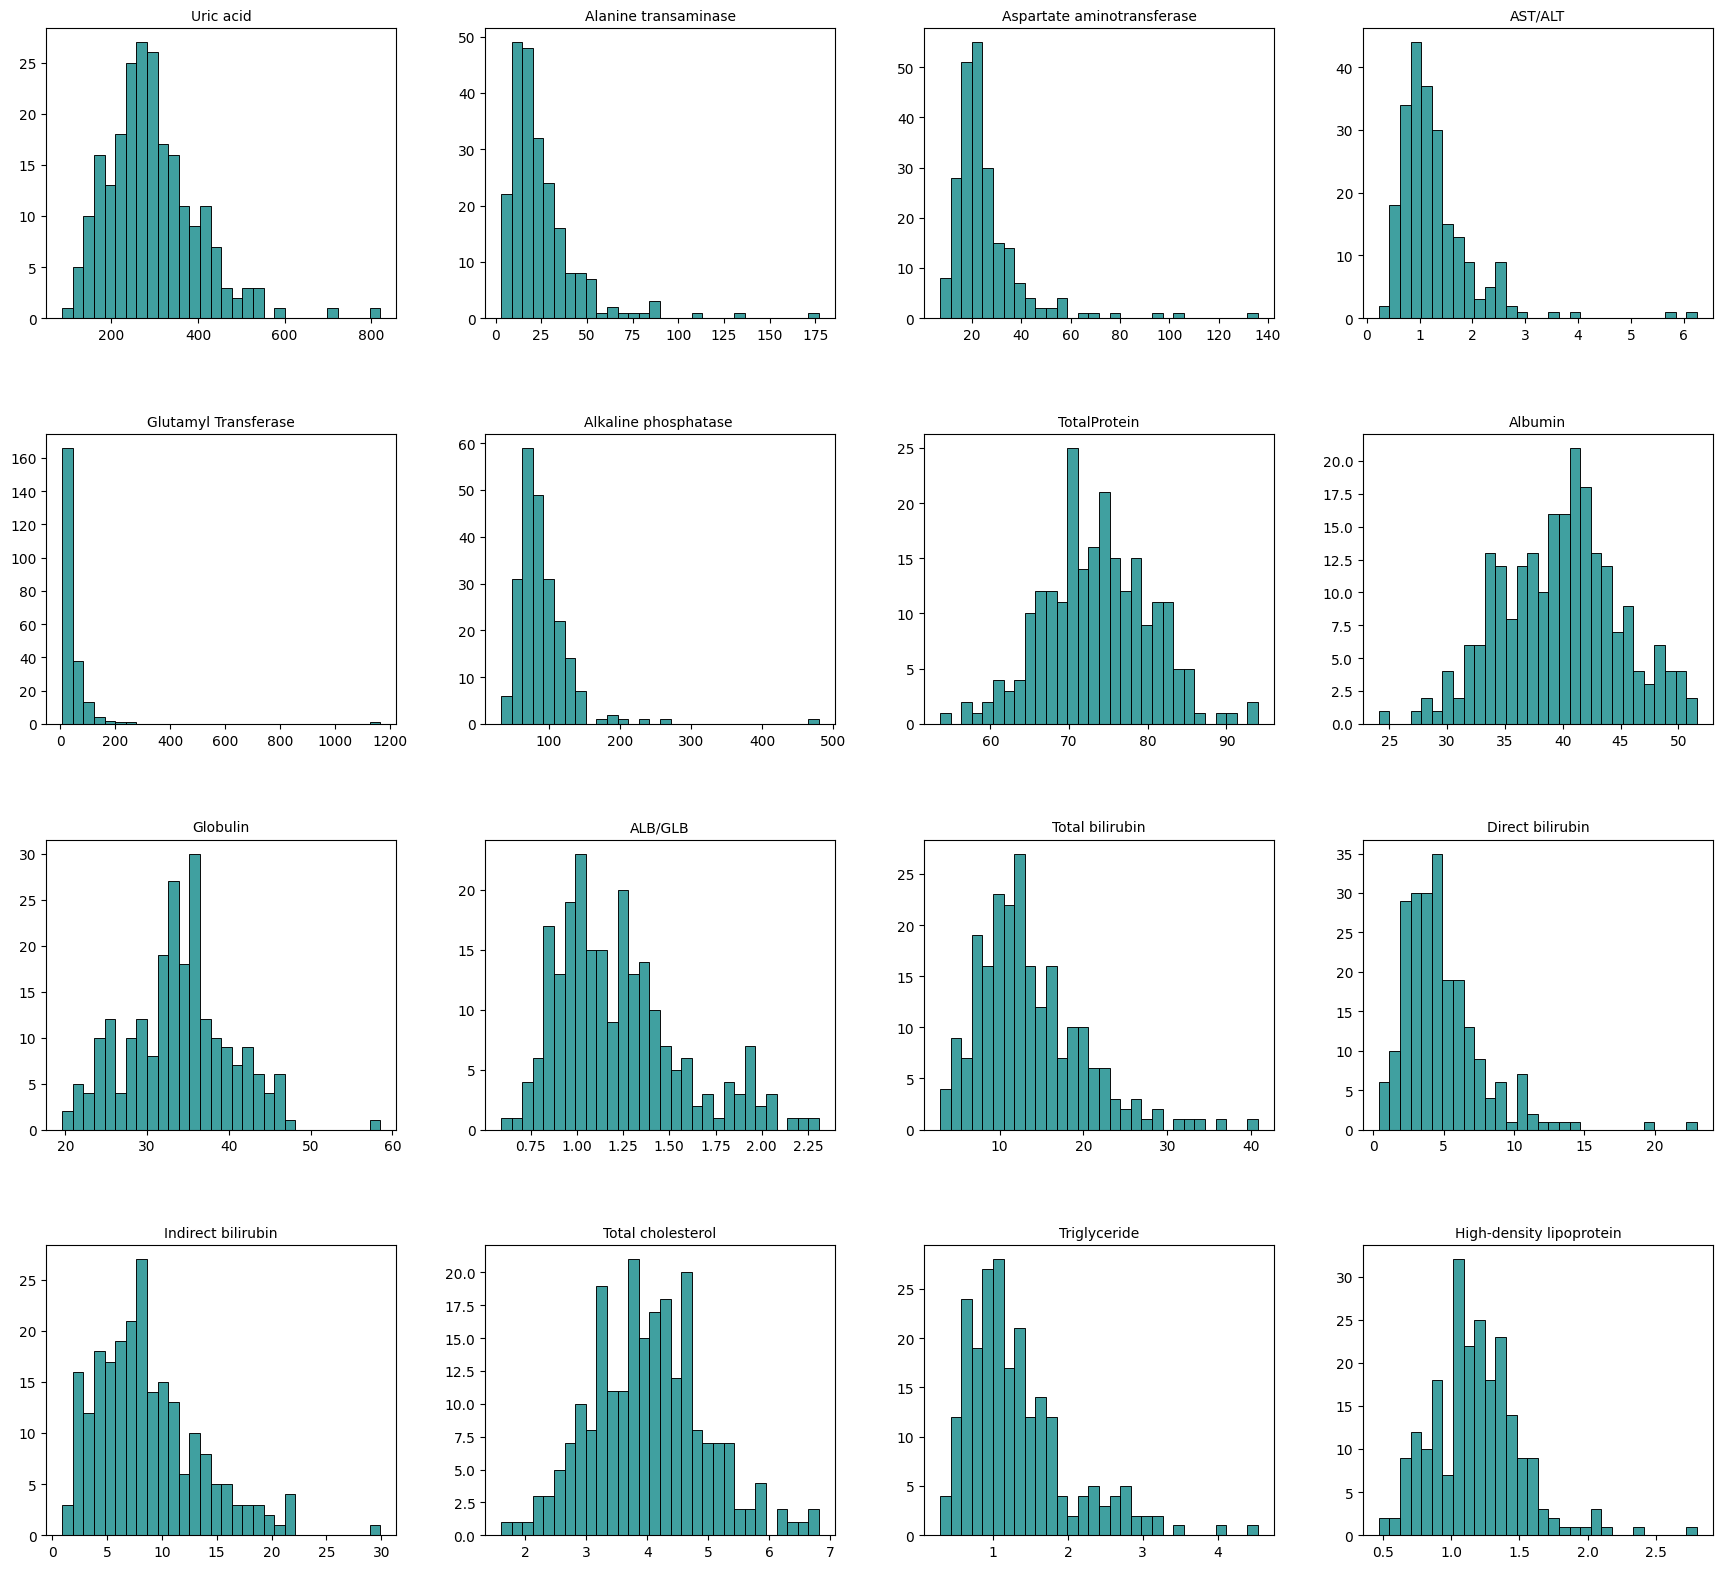

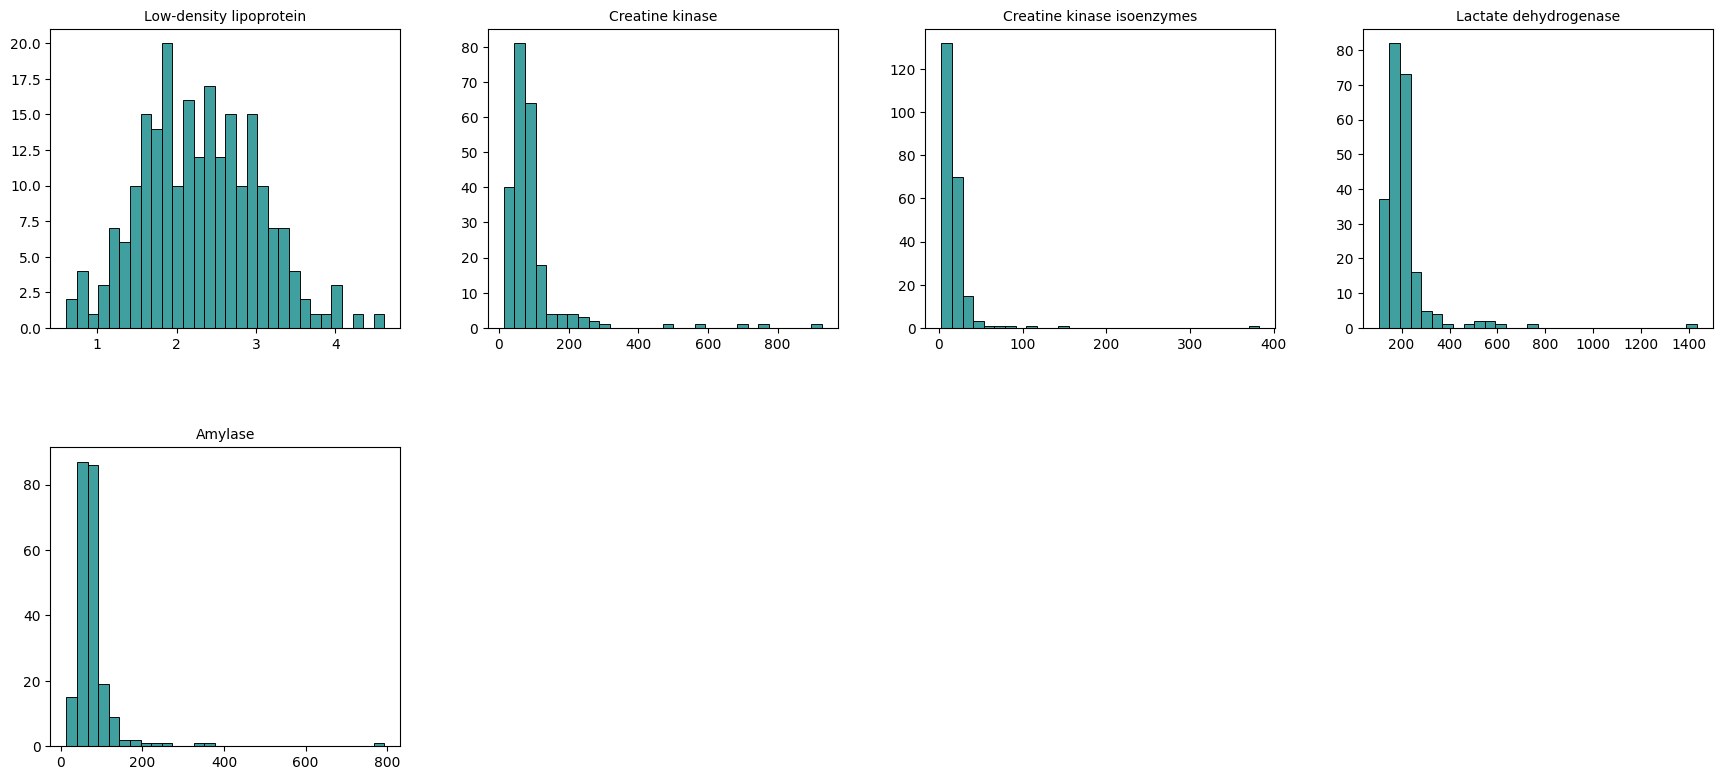

In [4]:
# =====================================================================
# 📊 Histograms (chunked 4×4 grids)
# =====================================================================

def chunk_columns(columns, chunk_size=16):
    """Split a list of columns into chunks of size `chunk_size`."""
    return [columns[i:i + chunk_size] for i in range(0, len(columns), chunk_size)]

all_cols = training_set.columns.tolist()
groups = chunk_columns(all_cols)

def plot_mixed_grid(cols):
    """Plot numeric cols as histograms; non-numeric as bar charts."""
    rows = math.ceil(len(cols) / 4)
    fig, axes = plt.subplots(rows, 4, figsize=(18, rows * 4.2))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        ax = axes[i]
        data = training_set[col].dropna()

        if pd.api.types.is_numeric_dtype(data):
            sns.histplot(data, bins=30, ax=ax, color='teal')
        else:
            counts = data.value_counts()
            sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='Set2')
            ax.set_xticklabels(counts.index, rotation=90, fontsize=8)

        ax.set_title(col, fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='x', labelbottom=True)
        ax.tick_params(axis='y', labelleft=True)

    # Hide any unused subplots
    for j in range(len(cols), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout(pad=3.5)
    plt.subplots_adjust(top=0.94, hspace=0.4)
    plt.show()

for group in groups:
    plot_mixed_grid(group)



In [5]:
# =====================================================================
# 🧪 Normality Testing (Kolmogorov–Smirnov)
# =====================================================================

exclude_cols = ['Label', 'Sex', 'Smoking status']
numeric_cols = training_set.select_dtypes(include='number').columns.drop(exclude_cols)

normality_results = []
for col in numeric_cols:
    data = training_set[col].dropna()
    standardized = (data - data.mean()) / data.std()
    stat, p_value = kstest(standardized, 'norm')

    normality_results.append({
        'Attribute': col,
        'K–S Statistic': round(stat, 4),
        'p-value': '<0.001' if p_value < 0.001 else round(p_value, 4),
        'Normality': 'Not normal' if p_value < 0.001 else 'Normal'
    })

normality_df = pd.DataFrame(normality_results)
print(normality_df.to_string(index=False))

# Export normality results
normality_df.to_csv("../outputs/normality_results.csv", index=False)
print("💾 Saved: outputs/normality_results.csv")


                                Attribute  K–S Statistic p-value  Normality
                                      Age         0.0927  0.0384     Normal
                         White blood cell         0.1547  <0.001 Not normal
            Neutrophile granulocyte ratio         0.0590  0.3953     Normal
                         Lymphocyte ratio         0.0645  0.2912     Normal
                           Monocyte ratio         0.1197  0.0028     Normal
                         Eosinophil ratio         0.2581  <0.001 Not normal
                           Basophil ratio         0.3809  <0.001 Not normal
                Neutrophilic granulocytes         0.1657  <0.001 Not normal
                              Lymphocytes         0.0576  0.4259     Normal
                                Monocytes         0.0793  0.1106     Normal
                         Eosinophil cells         0.2534  <0.001 Not normal
                           Basophil count         0.2041  <0.001 Not normal
            

In [6]:
# =====================================================================
# 📋 Table 1: Group Comparisons (Categorical: χ²; Numeric: t-test / Mann–Whitney)
# =====================================================================

# Split by class
lc = training_set[training_set['Label'] == 1]
non_lc = training_set[training_set['Label'] == 0]

# Pre-labeled non-normal features (from K–S)
non_normal_features = {
    'White blood cell', 'Eosinophil ratio', 'Basophil ratio', 'Neutrophilic granulocytes',
    'Eosinophil cells', 'Basophil count', 'Red blood cell distribution width - CV',
    'Platelet distribution width', 'Glucose', 'Alanine transaminase', 'Aspartate aminotransferase',
    'AST/ALT', 'Glutamyl Transferase', 'Alkaline phosphatase ', 'Creatine kinase',
    'Creatine kinase isoenzymes', 'Lactate dehydrogenase', 'Amylase'
}

summary = []

# --- Categorical variables (χ²) ---
cat_labels = {'Sex': 'Sex (m/f)', 'Smoking status': 'Smoking status (y/n)'}
for col, label in cat_labels.items():
    lc_counts = lc[col].value_counts().to_dict()
    non_counts = non_lc[col].value_counts().to_dict()

    lc_str = f"{lc_counts.get(1,0)}/{lc_counts.get(0,0)}"
    non_str = f"{non_counts.get(1,0)}/{non_counts.get(0,0)}"

    contingency = [[lc_counts.get(1,0), lc_counts.get(0,0)],
                   [non_counts.get(1,0), non_counts.get(0,0)]]
    _, p, _, _ = chi2_contingency(contingency)
    p_val = "<0.001" if p < 0.001 else round(p, 3)

    summary.append([label, "", lc_str, non_str, p_val])

# --- Numeric variables (t-test or Mann–Whitney) ---
num_cols = ['Age'] + training_set.select_dtypes(include='number') \
    .columns.drop(['Label', 'Sex', 'Smoking status', 'Age']).tolist()

for col in num_cols:
    lc_vals = lc[col].dropna()
    non_vals = non_lc[col].dropna()

    ref_min = training_set[col].min()
    ref_max = training_set[col].max()
    ref_interval = f"{ref_min:.2f}-{ref_max:.2f}"

    lc_median = lc_vals.median()
    lc_iqr = lc_vals.quantile(0.75) - lc_vals.quantile(0.25)
    non_median = non_vals.median()
    non_iqr = non_vals.quantile(0.75) - non_vals.quantile(0.25)

    lc_str = f"{lc_median:.2f} ({lc_iqr:.2f})"
    non_str = f"{non_median:.2f} ({non_iqr:.2f})"

    if col in non_normal_features:
        stat, p = mannwhitneyu(lc_vals, non_vals, alternative='two-sided')
        display_col = col + "*"  # flag non-normal
    else:
        stat, p = ttest_ind(lc_vals, non_vals, equal_var=False)
        display_col = col

    p_val = "<0.001" if p < 0.001 else round(p, 3)
    summary.append([display_col, ref_interval, lc_str, non_str, p_val])

df_summary = pd.DataFrame(
    summary,
    columns=["Attribute", "Reference interval", "LC (n=183)", "Non-LC (n=94)", "p-value"]
)

# Put Age first with a nicer label
df_summary.loc[df_summary['Attribute'] == 'Age', 'Attribute'] = 'Age, years'
df_summary = pd.concat([
    df_summary[df_summary['Attribute'] == 'Age, years'],
    df_summary[df_summary['Attribute'] != 'Age, years']
]).reset_index(drop=True)

print(df_summary.to_string(index=False))

# ✅ Export Table 1 to CSV
import os
os.makedirs("outputs", exist_ok=True)
df_summary.to_csv("../outputs/table1_summary.csv", index=False)
print("💾 Saved: outputs/table1_summary.csv")


                                Attribute Reference interval      LC (n=183)   Non-LC (n=94) p-value
                               Age, years        20.00-81.00   60.00 (14.00)   53.00 (19.00)  <0.001
                                Sex (m/f)                             113/40           29/44  <0.001
                     Smoking status (y/n)                             45/108            4/69  <0.001
                        White blood cell*         2.18-18.16     6.38 (2.97)     5.22 (1.46)  <0.001
            Neutrophile granulocyte ratio          0.27-0.93     0.69 (0.16)     0.61 (0.14)  <0.001
                         Lymphocyte ratio          0.03-0.60     0.21 (0.12)     0.30 (0.15)  <0.001
                           Monocyte ratio          0.00-0.15     0.06 (0.03)     0.06 (0.02)   0.276
                        Eosinophil ratio*          0.00-0.23     0.01 (0.02)     0.02 (0.01)   0.099
                          Basophil ratio*          0.00-0.02     0.00 (0.00)     0.01 (0.01

C:\Users\saifu\AppData\Local\Temp\ipykernel_3884\3602017703.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=training_set['Label'], y=training_set['outlier_count'], palette='Set3')


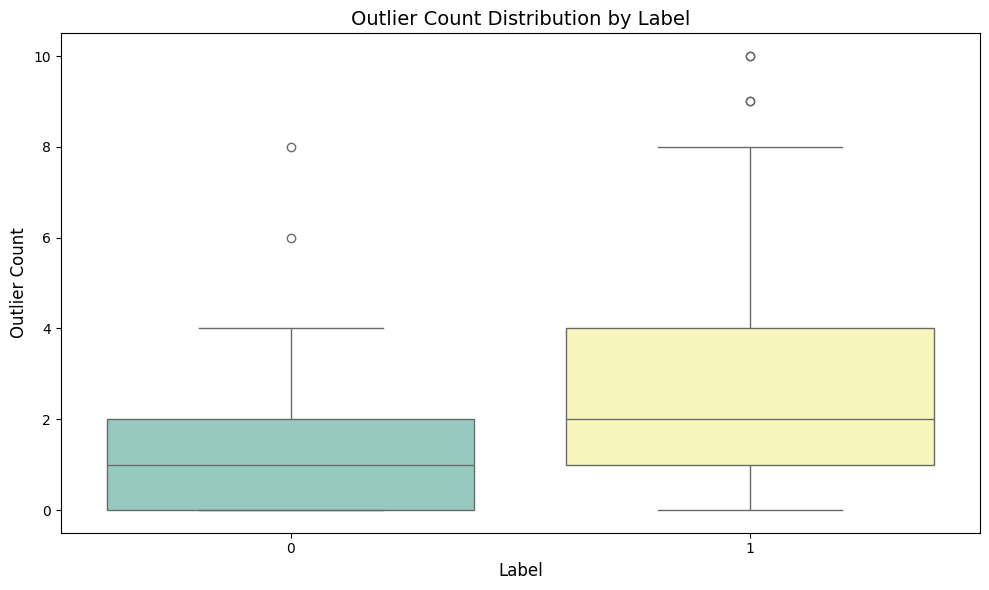

In [7]:
# =====================================================================
# 🚨 Outliers (IQR-based)
# =====================================================================

# 1) Numeric columns
numerical_cols = training_set.select_dtypes(include=['float64', 'int64']).columns

# 2) Compute IQR bounds on training set
def compute_iqr_bounds(df, cols):
    bounds = {}
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        bounds[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
    return bounds

iqr_bounds = compute_iqr_bounds(training_set, numerical_cols)

# 3) Flag outliers per column
def flag_outliers(df, bounds):
    flags = pd.DataFrame(False, index=df.index, columns=bounds.keys())
    for col, (lower, upper) in bounds.items():
        flags[col] = ~df[col].between(lower, upper)
    return flags

flags_train = flag_outliers(training_set, iqr_bounds)

# 4) Count how many features are outliers per row
training_set['outlier_count'] = flags_train.sum(axis=1)

# 5) Styled Excel with outliers highlighted
def highlight_outliers(val, is_outlier):
    return 'background-color: orange' if is_outlier else ''

styled = training_set[numerical_cols].style.apply(
    lambda col: [highlight_outliers(val, outlier) for val, outlier in zip(col, flags_train[col.name])],
    axis=0
)
styled.to_excel('../outputs/highlighted_outliers.xlsx', engine='openpyxl')

# Raw flags snapshot
flags_train.to_csv('../outputs/outlier_flags_train.csv', index=False)

# Quick boxplot viz
plt.figure(figsize=(10, 6))
sns.boxplot(x=training_set['Label'], y=training_set['outlier_count'], palette='Set3')
plt.title("Outlier Count Distribution by Label", fontsize=14)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Outlier Count", fontsize=12)
plt.tight_layout()
plt.show()

# Clean up helper column
training_set.drop(columns=['outlier_count'], inplace=True)


C:\Users\saifu\AppData\Local\Temp\ipykernel_3884\3085076175.py:67: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\saifu\anaconda6\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


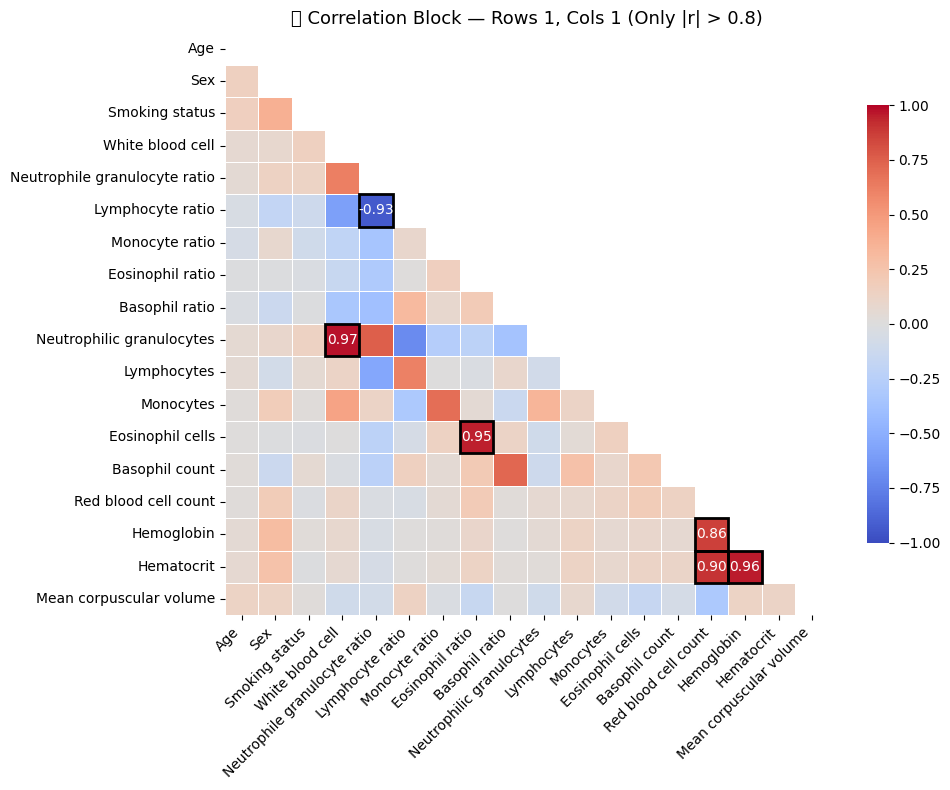

C:\Users\saifu\AppData\Local\Temp\ipykernel_3884\3085076175.py:67: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\saifu\anaconda6\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


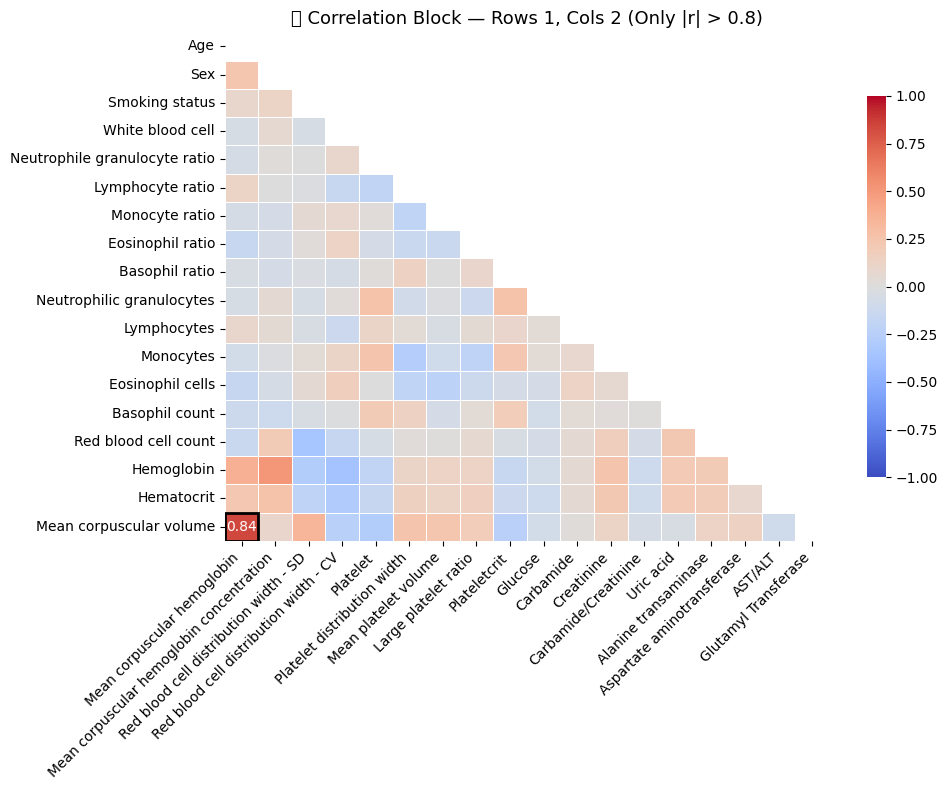

C:\Users\saifu\AppData\Local\Temp\ipykernel_3884\3085076175.py:67: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\saifu\anaconda6\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


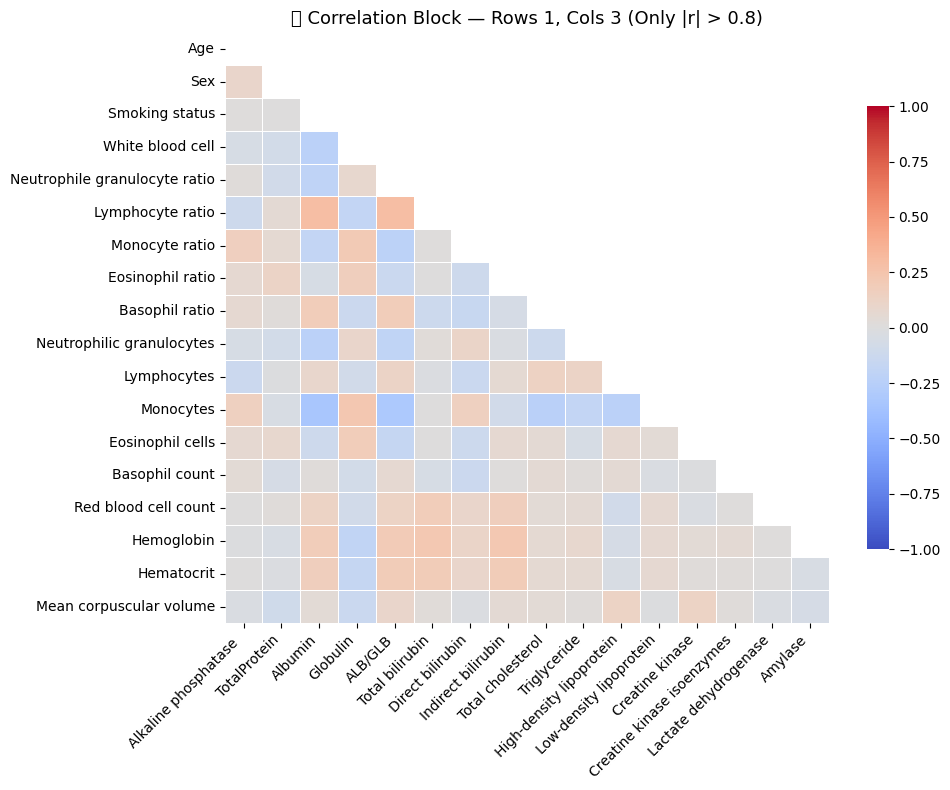

C:\Users\saifu\AppData\Local\Temp\ipykernel_3884\3085076175.py:67: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\saifu\anaconda6\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


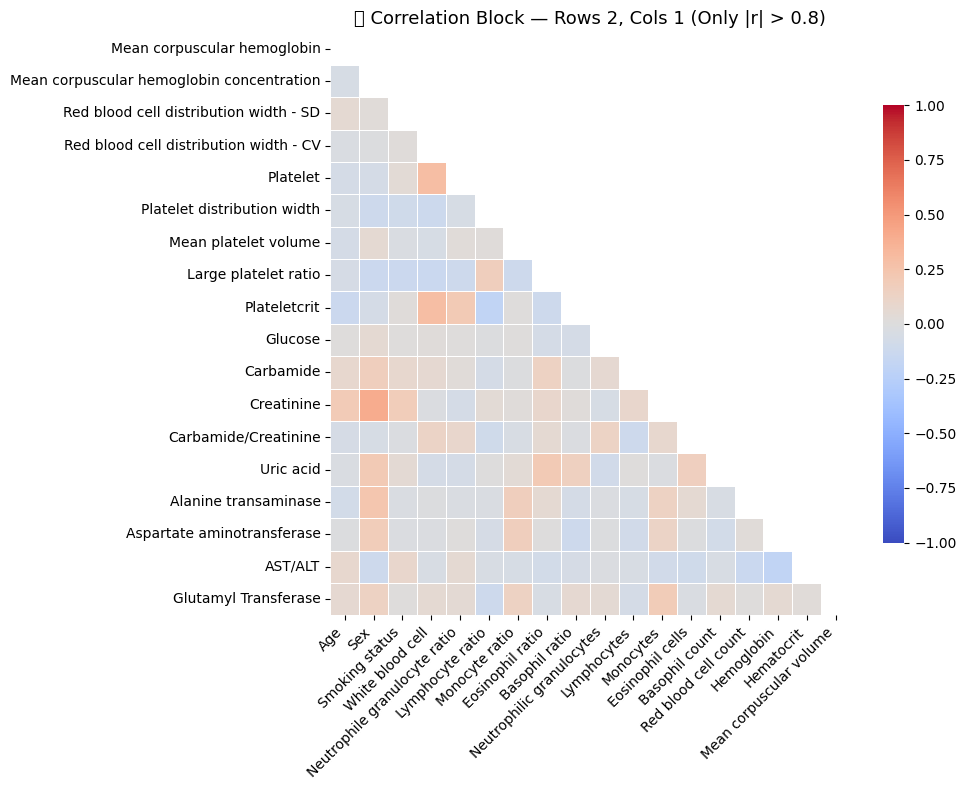

C:\Users\saifu\AppData\Local\Temp\ipykernel_3884\3085076175.py:67: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\saifu\anaconda6\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


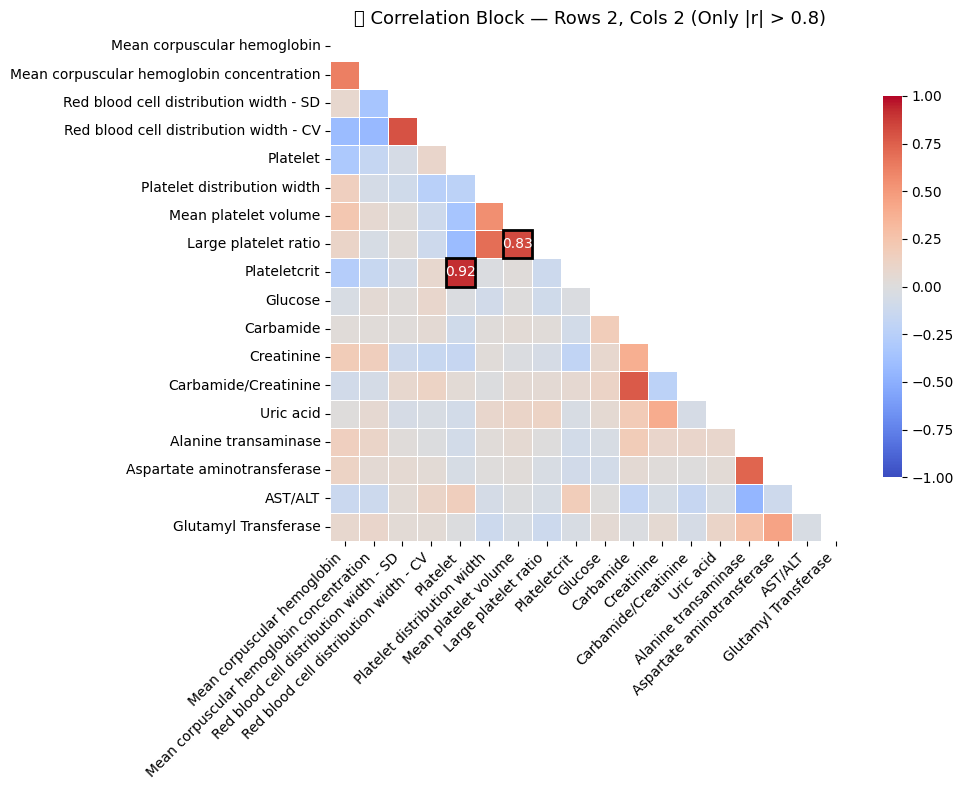

C:\Users\saifu\AppData\Local\Temp\ipykernel_3884\3085076175.py:67: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\saifu\anaconda6\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


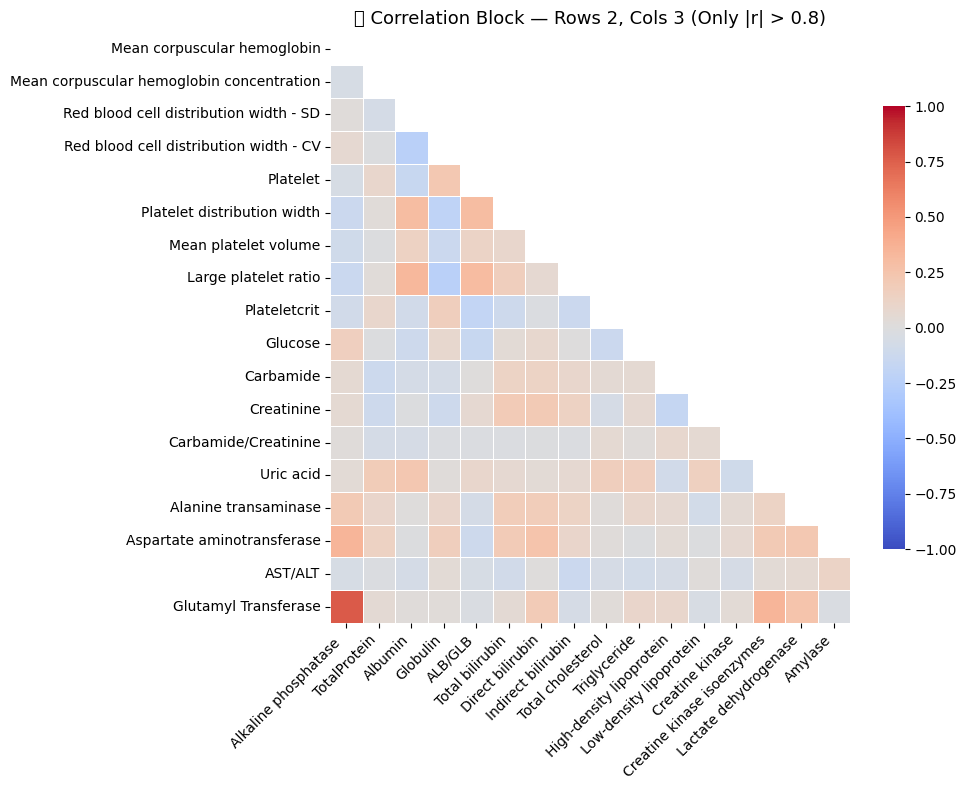

C:\Users\saifu\AppData\Local\Temp\ipykernel_3884\3085076175.py:67: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\saifu\anaconda6\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


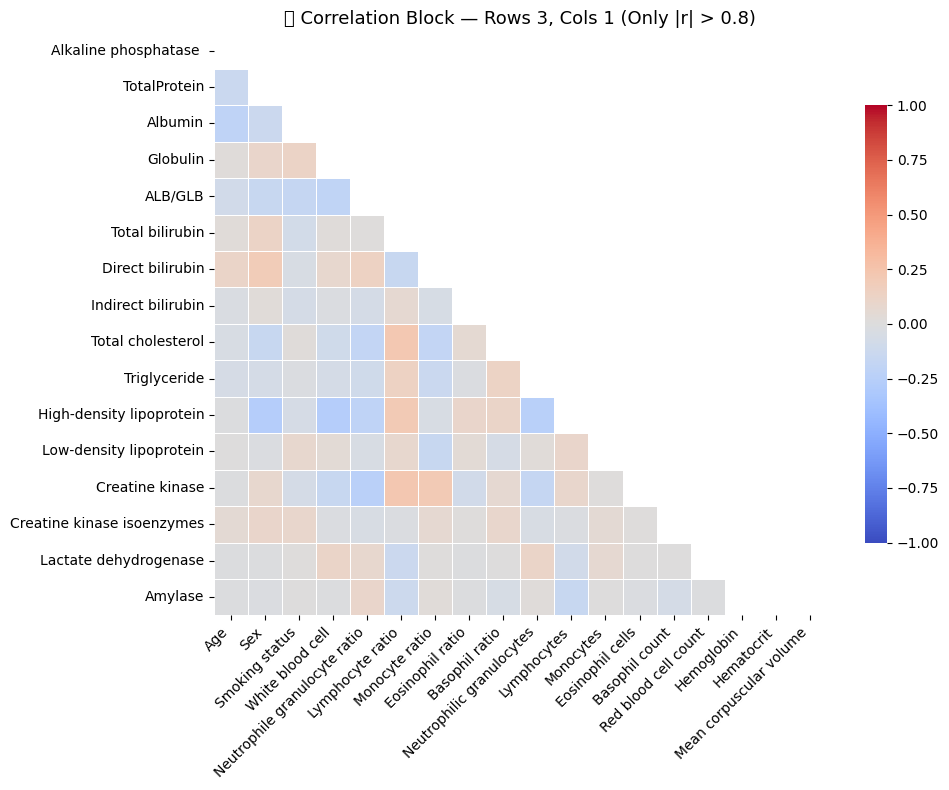

C:\Users\saifu\AppData\Local\Temp\ipykernel_3884\3085076175.py:67: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\saifu\anaconda6\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


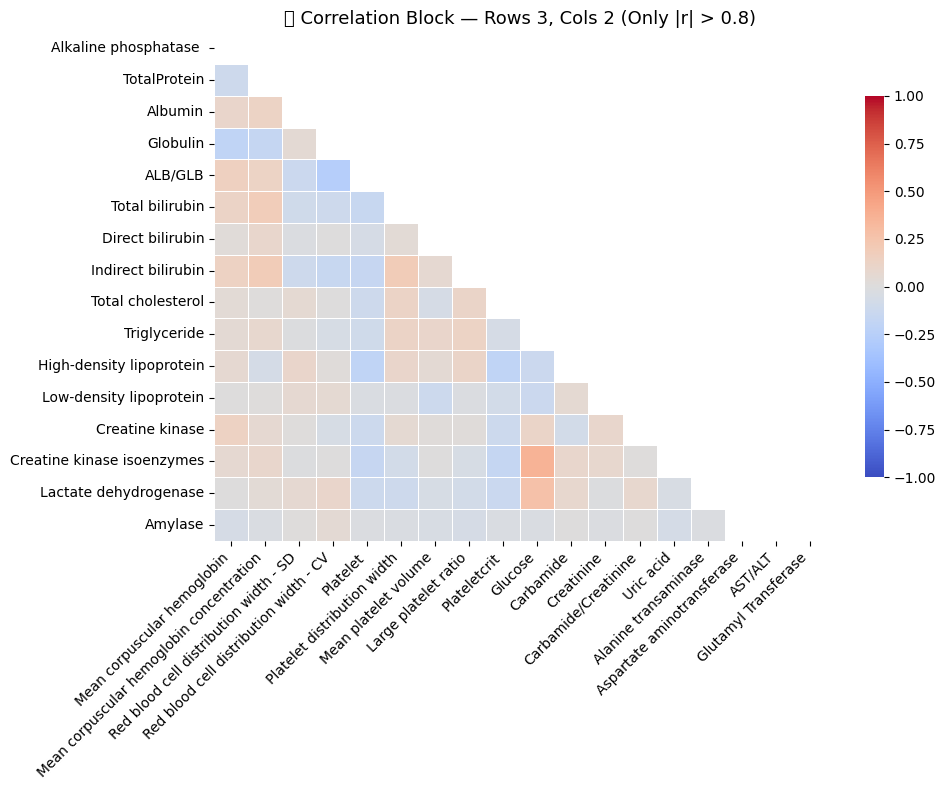

C:\Users\saifu\AppData\Local\Temp\ipykernel_3884\3085076175.py:67: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\saifu\anaconda6\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


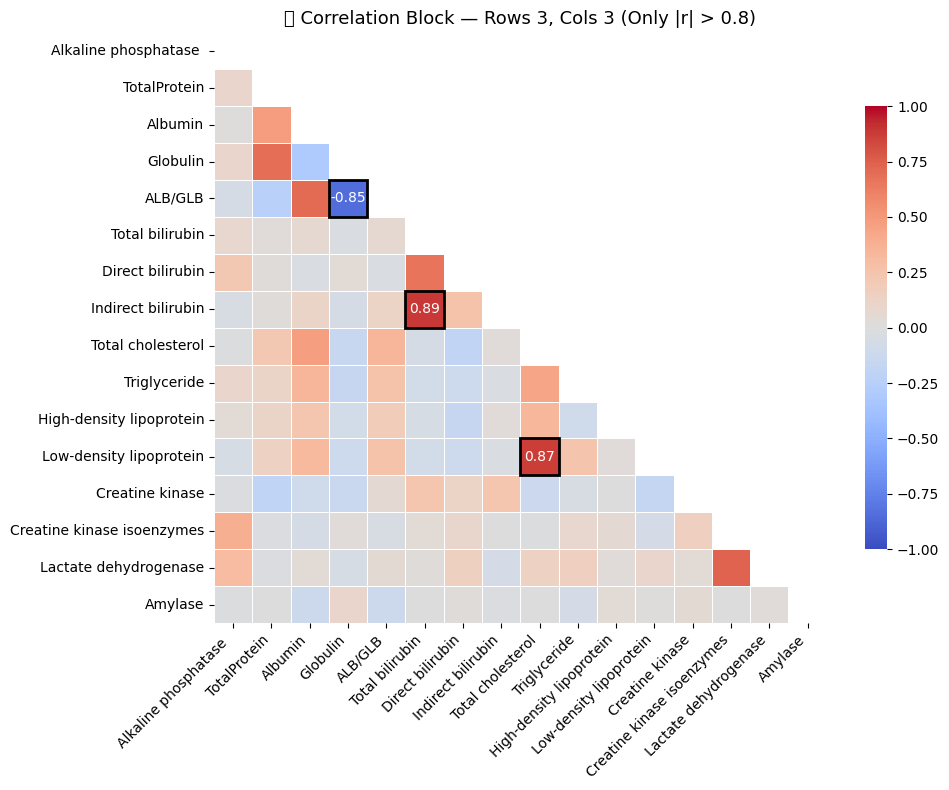

,Attribute 1,Attribute 2,Correlation
0,White blood cell,Neutrophilic granulocytes,0.97
1,Hemoglobin,Hematocrit,0.96
2,Eosinophil ratio,Eosinophil cells,0.95
3,Platelet,Plateletcrit,0.92
4,Red blood cell count,Hematocrit,0.90
5,Total bilirubin,Indirect bilirubin,0.89
6,Total cholesterol,Low-density lipoprotein,0.87
7,Red blood cell count,Hemoglobin,0.86
8,Mean corpuscular volume,Mean corpuscular hemoglobin,0.84
9,Mean platelet volume,Large platelet ratio,0.83


In [8]:
# =====================================================================
# 🔥 Correlation Analysis (blocks + pairs > |0.8|)
# =====================================================================

# Select numeric attributes (exclude label-like columns)
exclude_cols = ['Label', 'diagnosis', 'class', 'target']
numerical_cols = [
    col for col in training_set.select_dtypes(include=['float64', 'int64']).columns
    if col not in exclude_cols
]

def lower_triangle_corr_heatmap_blocks(df, cols, chunk_size=18, threshold=0.8):
    corr_full = df[cols].corr().round(2)
    chunks = [cols[i:i + chunk_size] for i in range(0, len(cols), chunk_size)]
    block_pairs = list(product(range(len(chunks)), repeat=2))  # (row_chunk, col_chunk)

    for r_idx, c_idx in block_pairs:
        rows = chunks[r_idx]
        cols_ = chunks[c_idx]
        sub_corr = corr_full.loc[rows, cols_]

        # Masking logic for lower triangle
        if r_idx == c_idx:
            mask = np.triu(np.ones(sub_corr.shape), k=0).astype(bool)
        else:
            mask = np.ones(sub_corr.shape, dtype=bool)
            for i in range(sub_corr.shape[0]):
                for j in range(sub_corr.shape[1]):
                    if i > j:
                        mask[i, j] = False

        # Annotate strong off-diagonal correlations only
        annotations = np.full(sub_corr.shape, '', dtype=object)
        for i in range(sub_corr.shape[0]):
            for j in range(sub_corr.shape[1]):
                is_not_masked = not mask[i, j]
                is_off_diagonal = rows[i] != cols_[j]
                is_strong = abs(sub_corr.iat[i, j]) > threshold
                if is_not_masked and is_off_diagonal and is_strong:
                    annotations[i, j] = f"{sub_corr.iat[i, j]:.2f}"

        # Bold borders for strong off-diagonal cells
        border_mask = (
            (np.abs(sub_corr) > threshold) &
            (~mask) &
            pd.DataFrame([[rows[i] != cols_[j] for j in range(len(cols_))]
                          for i in range(len(rows))],
                         index=sub_corr.index, columns=sub_corr.columns)
        )

        plt.figure(figsize=(10, 8))
        ax = sns.heatmap(
            sub_corr, mask=mask, annot=annotations, fmt='',
            cmap='coolwarm', vmin=-1, vmax=1,
            linewidths=0.5, linecolor='white',
            cbar_kws={"shrink": 0.75}
        )

        for y in range(sub_corr.shape[0]):
            for x in range(sub_corr.shape[1]):
                if border_mask.iat[y, x]:
                    ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='black', lw=2))

        plt.title(f'📊 Correlation Block — Rows {r_idx+1}, Cols {c_idx+1} (Only |r| > {threshold})', fontsize=13)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

lower_triangle_corr_heatmap_blocks(training_set, numerical_cols, chunk_size=18, threshold=0.8)

# Upper-triangle pairs |r| > 0.8 (no duplicates)
corr_matrix = training_set[numerical_cols].corr().round(2)
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

high_corr_pairs = (
    corr_matrix.where(mask)
    .stack()
    .reset_index()
    .rename(columns={0: 'Correlation', 'level_0': 'Attribute 1', 'level_1': 'Attribute 2'})
)

high_corr_pairs = high_corr_pairs[
    (high_corr_pairs['Correlation'].abs() > 0.8) & (high_corr_pairs['Correlation'].abs() < 1.0)
].sort_values(by='Correlation', ascending=False).reset_index(drop=True)

# Export high-corr pairs
high_corr_pairs.to_csv("../outputs/high_corr_pairs.csv", index=False)

high_corr_pairs  # display


In [9]:
# =====================================================================
# 🧮 Variance Inflation Factor (VIF) — targeted attributes
# =====================================================================

vif_pairs = [
        ("White blood cell", "Neutrophilic granulocytes"),
        ("Hemoglobin", "Hematocrit"),
        ("Eosinophil ratio", "Eosinophil cells"),
        ("Platelet", "Plateletcrit"),
        ("Red blood cell count", "Hematocrit"),
        ("Total bilirubin", "Indirect bilirubin"),
        ("Total cholesterol", "Low-density lipoprotein"),
        ("Red blood cell count", "Hemoglobin"),
        ("Mean corpuscular volume", "Mean corpuscular hemoglobin"),
        ("Mean platelet volume", "Large platelet ratio"),
        ("Globulin", "ALB/GLB"),
        ("Neutrophile granulocyte ratio", "Lymphocyte ratio"),
]

vif_attributes = sorted({attr for pair in vif_pairs for attr in pair})
# Only keep attributes that exist in training_set
attrs = [a for a in vif_attributes if a in training_set.columns]
missing = sorted(set(vif_attributes) - set(attrs))
if missing:
        print(f"⚠️ Skipping missing attributes not in training_set: {missing}")

vif_df = training_set[attrs].copy().dropna()
X = add_constant(vif_df)

vif_results = pd.DataFrame({
"Attribute": X.columns,
"VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

vif_results = (
vif_results[vif_results["Attribute"] != "const"]
.sort_values(by="VIF", ascending=False)
)

# Map attribute -> VIF from your computed table
vif_map = dict(zip(vif_results["Attribute"], vif_results["VIF"]))

# Build pair-wise table
rows = []
for a1, a2 in vif_pairs:
    rows.append({
        "Attribute 1": a1,
        "VIF 1": vif_map.get(a1, np.nan),
        "Attribute 2": a2,
        "VIF 2": vif_map.get(a2, np.nan),
        # "Dropped": ""  # ← optional: add your decision text here if you want a 'Dropped' column
    })

vif_pairs_df = pd.DataFrame(rows)

# Round & order columns
cols = ["Attribute 1", "VIF 1", "Attribute 2", "VIF 2"]
vif_pairs_df = vif_pairs_df[cols]
vif_pairs_df["VIF 1"] = vif_pairs_df["VIF 1"].round(2)
vif_pairs_df["VIF 2"] = vif_pairs_df["VIF 2"].round(2)

# Save CSV (pair format)
os.makedirs("outputs", exist_ok=True)
vif_pairs_df.to_csv("outputs/vif_pairs_results.csv", index=False)
print("💾 Saved: outputs/vif_pairs_results.csv")

# Pretty display (Notebook)
styler = (
    vif_pairs_df.style
    .set_caption("High Correlation Pairs with VIF Scores")
    .format({"VIF 1": "{:.2f}", "VIF 2": "{:.2f}"})
)

# Hide index (compat for pandas versions)
try:
    styler = styler.hide(axis="index")
except Exception:
    try:
        styler = styler.hide_index()
    except Exception:
        pass

styler


💾 Saved: outputs/vif_pairs_results.csv


Attribute 1,VIF 1,Attribute 2,VIF 2
White blood cell,67.27,Neutrophilic granulocytes,87.35
Hemoglobin,865.70,Hematocrit,1028.87
Eosinophil ratio,18.77,Eosinophil cells,18.09
Platelet,46.11,Plateletcrit,40.44
Red blood cell count,187.19,Hematocrit,1028.87
Total bilirubin,5.49,Indirect bilirubin,5.51
Total cholesterol,5.83,Low-density lipoprotein,5.05
Red blood cell count,187.19,Hemoglobin,865.70
Mean corpuscular volume,216.49,Mean corpuscular hemoglobin,227.93
Mean platelet volume,10.16,Large platelet ratio,5.31


Class distribution (Training Set):
Label
1    153
0     73
Name: count, dtype: int64


C:\Users\saifu\AppData\Local\Temp\ipykernel_3884\1600122165.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=training_set['Label'], palette='Set2')


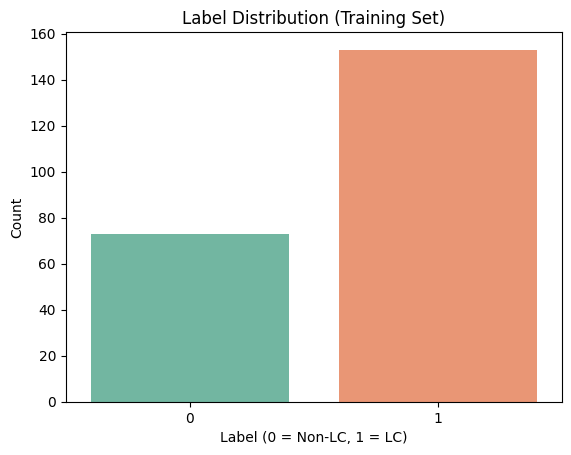

In [10]:
# =====================================================================
# 🧹 Feature Reduction — Drop Multicollinear Attributes
# =====================================================================

# Dropped features due to high correlation or redundancy:
#   Neutrophilic granulocytes, Hematocrit, Eosinophil cells, Plateletcrit,
#   Indirect bilirubin, Low-density lipoprotein, Mean corpuscular hemoglobin,
#   Large platelet ratio, ALB/GLB, Neutrophile granulocyte ratio
#   (also 'Label' separately handled for validation_set)
# =====================================================================

# --- Training set cleanup ---
training_set.drop(
    columns=[
        'Neutrophilic granulocytes', 'Hematocrit', 'Eosinophil cells',
        'Plateletcrit', 'Indirect bilirubin', 'Low-density lipoprotein',
        'Mean corpuscular hemoglobin', 'Large platelet ratio',
        'ALB/GLB', 'Neutrophile granulocyte ratio'
    ],
    inplace=True
)

# --- Validation set cleanup ---
# Preserve Label separately for evaluation
validation_set_label = validation_set['Label'].copy()

columns_to_drop = [
    'Neutrophilic granulocytes', 'Hematocrit', 'Eosinophil cells',
    'Plateletcrit', 'Indirect bilirubin', 'Low-density lipoprotein',
    'Mean corpuscular hemoglobin', 'Large platelet ratio',
    'ALB/GLB', 'Neutrophile granulocyte ratio', 'Label'
]
validation_set = validation_set.drop(columns=columns_to_drop)

# =====================================================================
# ⚖️ Class Balance Check (Training Set)
# =====================================================================

print("Class distribution (Training Set):")
print(training_set['Label'].value_counts())

sns.countplot(x=training_set['Label'], palette='Set2')
plt.title("Label Distribution (Training Set)")
plt.xlabel("Label (0 = Non-LC, 1 = LC)")
plt.ylabel("Count")
plt.show()


In [11]:
# =====================================================================
# 🔄 K-Fold Cross-Validation with SMOTE
# =====================================================================

# --- Define candidate models ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1_000_000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),
    "LightGBM": LGBMClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# --- Features & Target ---
X = training_set.drop(columns='Label')  # Features
y = training_set['Label']               # Target

# --- Store results ---
cv_results = []

# =====================================================================
# 🚀 Run CV for different fold values (k=5,7,10)
# =====================================================================
for k in [5, 7, 10]:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    for model_name, base_model in models.items():
        # Collect fold metrics
        metrics = {'Accuracy': [], 'Sensitivity': [], 'Specificity': [], 'Precision': [], 'AUC': []}

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # --- Pipeline: SMOTE + Classifier ---
            pipe = ImbPipeline([
                ('smote', SMOTE(sampling_strategy=1.0, k_neighbors=5, random_state=42)),
                ('clf', base_model)
            ])
            pipe.fit(X_train, y_train)

            # Predictions
            y_pred = pipe.predict(X_test)
            y_prob = pipe.predict_proba(X_test)[:, 1]

            # Confusion matrix breakdown
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

            # Store metrics
            metrics['Accuracy'].append(accuracy_score(y_test, y_pred) * 100)
            metrics['Sensitivity'].append(tp / (tp + fn))
            metrics['Specificity'].append(tn / (tn + fp))
            metrics['Precision'].append(precision_score(y_test, y_pred))
            metrics['AUC'].append(roc_auc_score(y_test, y_prob))

        # --- Aggregate mean performance ---
        cv_results.append({
            "Model": model_name,
            "CV Folds": k,
            "Accuracy (%)": np.mean(metrics['Accuracy']),
            "Sensitivity": np.mean(metrics['Sensitivity']),
            "Specificity": np.mean(metrics['Specificity']),
            "Precision": np.mean(metrics['Precision']),
            "AUC": np.mean(metrics['AUC'])
        })

# =====================================================================
# 📊 Final Results Table
# =====================================================================
results_df = pd.DataFrame(cv_results)
print(results_df.round(3))

# --- Export results to CSV ---
results_df.to_csv("../outputs/kfold_cv_results.csv", index=False)
print("\n✅ Cross-validation results saved to 'outputs/kfold_cv_results.csv'")


C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 122, number of negative: 122
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2394
[LightGBM] [Info] Number of data points in the train set: 244, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\saifu\anaconda6\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:16:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\saifu\anaconda6\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:16:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\saifu\anaconda6\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:16:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\saifu\anaconda6\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:16:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 131, number of negative: 131
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2531
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\saifu\anaconda6\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:16:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\saifu\anaconda6\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:16:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\saifu\anaconda6\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:16:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\saifu\anaconda6\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:16:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 137, number of negative: 137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2618
[LightGBM] [Info] Number of data points in the train set: 274, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\saifu\anaconda6\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:17:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\saifu\anaconda6\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:17:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\saifu\anaconda6\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:17:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\saifu\anaconda6\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:17:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

                     Model  CV Folds  Accuracy (%)  Sensitivity  Specificity  \
0      Logistic Regression         5        85.816        0.869        0.834   
1            Random Forest         5        86.725        0.967        0.657   
2   Support Vector Machine         5        62.870        0.549        0.790   
3              Naive Bayes         5        78.715        0.803        0.754   
4                 LightGBM         5        86.261        0.954        0.670   
5                 AdaBoost         5        86.261        0.902        0.779   
6                  XGBoost         5        86.271        0.941        0.696   
7      Logistic Regression         7        84.037        0.843        0.834   
8            Random Forest         7        85.430        0.974        0.606   
9   Support Vector Machine         7        65.977        0.601        0.779   
10             Naive Bayes         7        76.948        0.777        0.756   
11                LightGBM         7    

In [12]:
# =====================================================================
# 🎯 GRIDSEARCHCV for Hyperparameter Tuning
# =====================================================================

# --- Custom Scorers ---
def specificity_score(y_true, y_pred):
    """Calculate specificity = TN / (TN + FP)."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def custom_auc(y_true, y_pred_proba):
    """Custom AUC scorer using predicted probabilities."""
    return roc_auc_score(y_true, y_pred_proba)

# --- Multi-metric scoring dictionary ---
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(specificity_score),
    'precision': make_scorer(precision_score),
    'roc_auc': make_scorer(custom_auc, needs_proba=True)
}

# =====================================================================
# ⚙️ Model Configurations + Search Spaces
# =====================================================================
models_grids = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=10000, random_state=42),  # try max_iter=-1 for infinity?
        "params": {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['l2'],
            'clf__solver': ['liblinear', 'lbfgs'],
            'clf__class_weight': [None, 'balanced'],
            'clf__fit_intercept': [True, False]
        },
        "cv": 5
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {
            'clf__var_smoothing': [1e-9, 1e-8, 1e-7]
        },
        "cv": 5
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [5, 10, 15],
            'clf__min_samples_split': [2, 5],
            'clf__min_samples_leaf': [2, 4],
            'clf__max_features': ['sqrt', 'log2'],
            'clf__class_weight': ['balanced'],
            'clf__criterion': ['gini', 'entropy']
        },
        "cv": 7
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            'clf__n_estimators': [50, 100, 200],
            'clf__learning_rate': [0.01, 0.1, 0.5, 1.0],
            'clf__algorithm': ['SAMME', 'SAMME.R'],
            'clf__estimator': [DecisionTreeClassifier(max_depth=d) for d in [1, 2, 3]]
        },
        "cv": 5
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [3, 6],
            'clf__learning_rate': [0.01, 0.1],
            'clf__subsample': [0.7, 1.0],
            'clf__colsample_bytree': [0.7, 1.0],
            'clf__gamma': [0, 1],
            'clf__min_child_weight': [1, 3],
            'clf__reg_alpha': [0, 0.1],
            'clf__reg_lambda': [1, 5],
            'clf__scale_pos_weight': [1, 2]
        },
        "cv": 7
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42),
        "params": {
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [3, 6],
            'clf__learning_rate': [0.01, 0.1],
            'clf__subsample': [0.7, 1.0],
            'clf__colsample_bytree': [0.7, 1.0],
            'clf__min_child_samples': [10, 20],
            'clf__reg_alpha': [0, 0.1],
            'clf__reg_lambda': [1, 5],
            'clf__class_weight': [None, 'balanced'],
            'clf__boosting_type': ['gbdt']
        },
        "cv": 10
    },
    "Support Vector Machine": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf'],
            'clf__gamma': ['scale', 'auto']
        },
        "cv": 10
    }
}

# =====================================================================
# 📊 Evaluation Helper
# =====================================================================
def evaluate_model(model, X, y):
    """Evaluate best estimator on training set with multiple metrics."""
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return {
        "Accuracy (%)": accuracy_score(y, y_pred) * 100,
        "Sensitivity": recall_score(y, y_pred),
        "Specificity": tn / (tn + fp),
        "Precision": precision_score(y, y_pred),
        "AUC": roc_auc_score(y, y_prob)
    }

# =====================================================================
# 🚀 Main GridSearch Runner
# =====================================================================
def run_gridsearch(X, y):
    pd.set_option('display.max_colwidth', None)
    results = {}

    for name, cfg in models_grids.items():
        print(f"\n🔍 Tuning {name}...")

        # --- Pipeline: Scaling + SMOTE + Classifier ---
        pipeline = ImbPipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('clf', cfg['model'])
        ])

        # --- GridSearchCV ---
        grid = GridSearchCV(
            pipeline,
            param_grid=cfg['params'],
            scoring=scoring,
            refit='roc_auc',
            cv=StratifiedKFold(n_splits=cfg['cv'], shuffle=True, random_state=42),
            n_jobs=-1
        )

        # Fit search
        grid.fit(X, y)

        # Evaluate best model
        metrics = evaluate_model(grid.best_estimator_, X, y)

        # Store results
        results[name] = {
            "Best Params": grid.best_params_,
            **metrics
        }

        # Print quick summary
        for k, v in metrics.items():
            print(f"{k}: {v:.4f}")

    # --- Results DataFrame ---
    results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})
    print("\n📊 Full Results:")
    print(results_df)

    return results


# =====================================================================
# 🏃 Run GridSearch on Training Data
# =====================================================================
label_col = 'Label'
X = training_set.drop(columns=[label_col])
y = training_set[label_col]

results = run_gridsearch(X, y)

# --- Save Results to CSV ---
pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'}).to_csv("../outputs/initial_gridsearch_results.csv", index=False
)
print("\n✅ GridSearchCV results saved to 'outputs/initial_gridsearch_results.csv'")




🔍 Tuning Logistic Regression...


C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


Accuracy (%): 79.6460
Sensitivity: 0.7516
Specificity: 0.8904
Precision: 0.9350
AUC: 0.9357

🔍 Tuning Naive Bayes...
Accuracy (%): 78.3186
Sensitivity: 0.7647
Specificity: 0.8219
Precision: 0.9000
AUC: 0.8926

🔍 Tuning Random Forest...


C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


Accuracy (%): 98.6726
Sensitivity: 1.0000
Specificity: 0.9589
Precision: 0.9808
AUC: 1.0000

🔍 Tuning AdaBoost...


C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\saifu\anaconda6\Lib\site-packages\imblearn\pipeline.py", line 526, in fit
    self._final_estimator

Accuracy (%): 73.4513
Sensitivity: 0.7582
Specificity: 0.6849
Precision: 0.8345
AUC: 0.8170

🔍 Tuning XGBoost...


C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
C:\Users\saifu\anaconda6\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:24:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy (%): 95.5752
Sensitivity: 0.9935
Specificity: 0.8767
Precision: 0.9441
AUC: 0.9919

🔍 Tuning LightGBM...


C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan 

[LightGBM] [Info] Number of positive: 153, number of negative: 153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2944
[LightGBM] [Info] Number of data points in the train set: 306, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


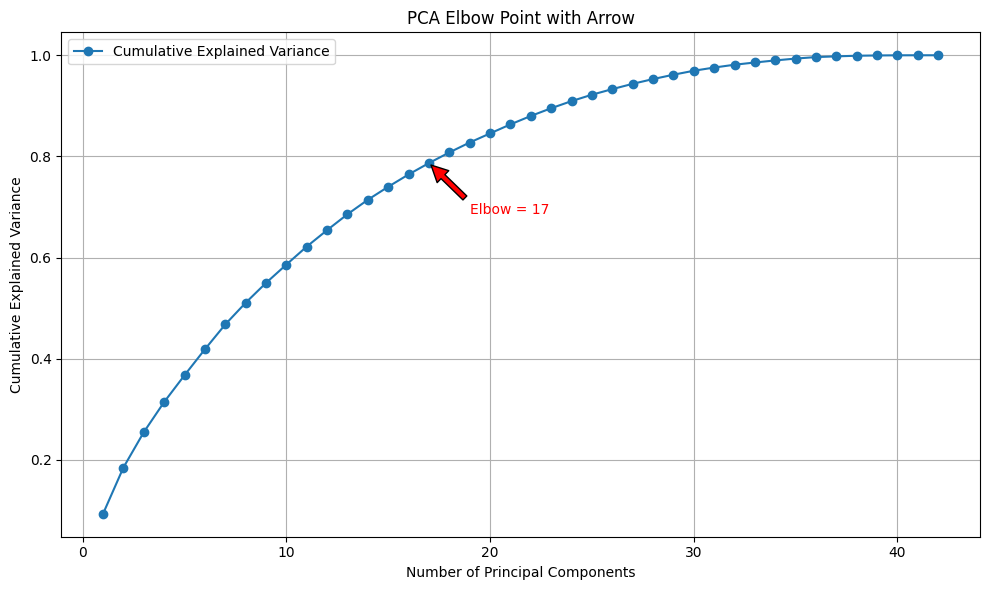

🔍 PCA Elbow at 17 components (78.69% variance explained)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 153, number of negative: 73
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2015
[LightGBM] [Info] Number of data points in the train set: 226, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.676991 -> initscore=0.739978
[LightGBM] [Info] Start training from score 0.739978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

C:\Users\saifu\anaconda6\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:28:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [13]:
# =====================================================================
# 🔎 Feature Extraction & Ranking
# =====================================================================

# --- Standardize Features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =====================================================================
# 📉 PCA Analysis
# =====================================================================
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# --- Cumulative explained variance ---
explained_var = np.cumsum(pca.explained_variance_ratio_)
components = np.arange(1, len(explained_var) + 1)

# --- Elbow detection with KneeLocator ---
knee = KneeLocator(components, explained_var, curve='concave', direction='increasing')
elbow_point = knee.knee
elbow_value = explained_var[elbow_point - 1] if elbow_point else None

# --- Plot PCA elbow ---
plt.figure(figsize=(10, 6))
plt.plot(components, explained_var, marker='o', label="Cumulative Explained Variance")
plt.annotate(
    f"Elbow = {elbow_point}",
    xy=(elbow_point, elbow_value),
    xytext=(elbow_point + 2, elbow_value - 0.1),
    arrowprops=dict(facecolor='red', shrink=0.05),
    fontsize=10,
    color='red'
)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Elbow Point with Arrow")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"🔍 PCA Elbow at {elbow_point} components ({elbow_value:.2%} variance explained)")

# =====================================================================
# 📊 Feature Importance Ranking
# =====================================================================
X = training_set.drop(columns=['Label'])
y = training_set['Label']
features = X.columns

# --- Step 1: Mutual Information ---
mi_scores = mutual_info_classif(X, y, random_state=42)

# --- Step 2: Model-based Feature Importances ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
rf_scores = rf.feature_importances_

xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X, y)
xgb_scores = xgb.feature_importances_

lgbm = LGBMClassifier(n_estimators=100, random_state=42)
lgbm.fit(X, y)
lgbm_scores = lgbm.feature_importances_

# --- Step 3: Combine Scores ---
df = pd.DataFrame({
    'Feature': features,
    'Mutual_Info': mi_scores,
    'RF_Importance': rf_scores,
    'XGB_Importance': xgb_scores,
    'LGBM_Importance': lgbm_scores
})

# --- Step 4: Compute Ranks ---
for col in ['Mutual_Info', 'RF_Importance', 'XGB_Importance', 'LGBM_Importance']:
    df[f'{col}_Rank'] = df[col].rank(ascending=False, method='min')

# --- Step 5: Average rank across methods ---
rank_cols = [col for col in df.columns if col.endswith('_Rank')]
df['Avg_Rank'] = df[rank_cols].mean(axis=1)

# --- Step 6: Sort & select Top 17 ---
df_sorted = df.sort_values('Avg_Rank').reset_index(drop=True)
top_17 = df_sorted.head(17)

# --- Display ---
print("\n🏆 Top 17 Features by Average Rank:")
print(top_17[['Feature', 'Mutual_Info', 'Mutual_Info_Rank',
              'RF_Importance', 'RF_Importance_Rank',
              'XGB_Importance', 'XGB_Importance_Rank',
              'LGBM_Importance', 'LGBM_Importance_Rank',
              'Avg_Rank']])

# --- Save results to CSV ---
top_17.to_csv("../outputs/top_17_features.csv", index=False)
print("\n✅ Top 17 features saved to 'outputs/top_17_features.csv'")



In [14]:
# =====================================================================
# 🧰 Setup: Clean Column Names & Define Top-17 Features
# =====================================================================

# Clean column names
training_set.columns = training_set.columns.str.strip().str.replace('\xa0', ' ', regex=True)
validation_set.columns = validation_set.columns.str.strip().str.replace('\xa0', ' ', regex=True)

# Handpicked Top-17 features
top_17_features = [
    'Creatine kinase isoenzymes', 'Albumin', 'Basophil ratio', 'Monocytes',
    'Monocyte ratio', 'Creatine kinase', 'Lymphocyte ratio',
    'Platelet distribution width', 'White blood cell', 'Alkaline phosphatase',
    'Age', 'Aspartate aminotransferase', 'Lactate dehydrogenase',
    'Glucose', 'Carbamide', 'Mean corpuscular volume', 'Globulin'
]

# Filter datasets
training_set_filtered   = training_set[top_17_features]
validation_set_filtered = validation_set[top_17_features]

# Inputs
label_col = 'Label'
X = training_set_filtered
y = training_set[label_col]


In [15]:
# =====================================================================
# 🎯 Scorers (Accuracy, Sensitivity, Specificity, Precision, ROC AUC)
# =====================================================================

def specificity_score(y_true, y_pred):
    """Specificity = TN / (TN + FP)."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def custom_auc(y_true, y_pred_proba):
    """AUC based on predicted probabilities."""
    return roc_auc_score(y_true, y_pred_proba)

scoring = {
    'accuracy':    make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(specificity_score),
    'precision':   make_scorer(precision_score),
    'roc_auc':     make_scorer(custom_auc, needs_proba=True)
}


In [16]:
# =====================================================================
# ⚙️ Model Grids (Top-17 Features)
# =====================================================================

models_grids = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=10000, random_state=42),
        "params": {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['l2'],
            'clf__solver': ['liblinear', 'lbfgs'],
            'clf__class_weight': [None, 'balanced'],
            'clf__fit_intercept': [True, False]
        },
        "cv": 5
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {
            'clf__var_smoothing': [1e-9, 1e-8, 1e-7]
        },
        "cv": 5
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [5, 10, 15],
            'clf__min_samples_split': [2, 5],
            'clf__min_samples_leaf': [2, 4],
            'clf__max_features': ['sqrt', 'log2'],
            'clf__class_weight': ['balanced'],
            'clf__criterion': ['gini', 'entropy']
        },
        "cv": 5
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            'clf__n_estimators': [50, 100, 200],
            'clf__learning_rate': [0.01, 0.1, 0.5, 1.0],
            'clf__algorithm': ['SAMME', 'SAMME.R'],
            'clf__estimator': [DecisionTreeClassifier(max_depth=d) for d in [1, 2, 3]]
        },
        "cv": 5
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [3, 6],
            'clf__learning_rate': [0.01, 0.1],
            'clf__subsample': [0.7, 1.0],
            'clf__colsample_bytree': [0.7, 1.0],
            'clf__gamma': [0, 1],
            'clf__min_child_weight': [1, 3],
            'clf__reg_alpha': [0, 0.1],
            'clf__reg_lambda': [1, 5],
            'clf__scale_pos_weight': [1, 2]
        },
        "cv": 7
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42),
        "params": {
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [3, 6],
            'clf__learning_rate': [0.01, 0.1],
            'clf__subsample': [0.7, 1.0],
            'clf__colsample_bytree': [0.7, 1.0],
            'clf__min_child_samples': [10, 20],
            'clf__reg_alpha': [0, 0.1],
            'clf__reg_lambda': [1, 5],
            'clf__class_weight': [None, 'balanced'],
            'clf__boosting_type': ['gbdt']
        },
        "cv": 10
    },
    "Support Vector Machine": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf'],
            'clf__gamma': ['scale', 'auto']
        },
        "cv": 10
    }
}


In [17]:
# =====================================================================
# 📊 Evaluation Helper
# =====================================================================

def evaluate_model(model, X, y):
    """Return a dict of metrics for a fitted model on given X/y."""
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return {
        "Accuracy (%)": accuracy_score(y, y_pred) * 100,
        "Sensitivity":   recall_score(y, y_pred),
        "Specificity":   tn / (tn + fp),
        "Precision":     precision_score(y, y_pred),
        "AUC":           roc_auc_score(y, y_prob)
    }


In [18]:
# =====================================================================
# 🚀 GridSearch Runner (Top-17 features)
# =====================================================================

def run_gridsearch(X, y):
    pd.set_option('display.max_colwidth', None)
    results = {}

    for name, cfg in models_grids.items():
        print(f"\n🔍 Tuning {name}...")

        # Pipeline: scale → SMOTE → classifier
        pipeline = ImbPipeline([
            ('scaler', StandardScaler()),
            ('smote',  SMOTE(random_state=42)),
            ('clf',    cfg['model'])
        ])

        grid = GridSearchCV(
            pipeline,
            param_grid=cfg['params'],
            scoring=scoring,
            refit='roc_auc',
            cv=StratifiedKFold(n_splits=cfg['cv'], shuffle=True, random_state=42),
            n_jobs=-1
        )

        grid.fit(X, y)
        metrics = evaluate_model(grid.best_estimator_, X, y)

        results[name] = {"Best Params": grid.best_params_, **metrics}

        # Quick on-screen summary
        for k, v in metrics.items():
            print(f"{k}: {v:.4f}")

    results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})
    print("\n📊 Full Results:")
    print(results_df)
    return results


In [19]:
# =====================================================================
# 🏁 Run Search + Save Results (Top-17)
# =====================================================================

results = run_gridsearch(X, y)

# Save to CSV (metrics + best params per model)
import os, json
os.makedirs("outputs", exist_ok=True)

results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})

# Expand "Best Params" dict into columns for easy reading
best_params_df = pd.json_normalize(results_df["Best Params"])
final_df = pd.concat([results_df.drop(columns=["Best Params"]), best_params_df], axis=1)

final_df.to_csv("outputs/gridsearch_results_top17.csv", index=False)
print("💾 Saved: outputs/gridsearch_results_top17.csv")



🔍 Tuning Logistic Regression...


C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


Accuracy (%): 78.7611
Sensitivity: 0.7516
Specificity: 0.8630
Precision: 0.9200
AUC: 0.9060

🔍 Tuning Naive Bayes...
Accuracy (%): 69.9115
Sensitivity: 0.6405
Specificity: 0.8219
Precision: 0.8829
AUC: 0.8671

🔍 Tuning Random Forest...


C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


Accuracy (%): 97.7876
Sensitivity: 1.0000
Specificity: 0.9315
Precision: 0.9684
AUC: 0.9989

🔍 Tuning AdaBoost...


C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\saifu\anaconda6\Lib\site-packages\imblearn\pipeline.py", line 526, in fit
    self._final_estimator

Accuracy (%): 73.4513
Sensitivity: 0.7582
Specificity: 0.6849
Precision: 0.8345
AUC: 0.8231

🔍 Tuning XGBoost...


C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
C:\Users\saifu\anaconda6\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:33:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy (%): 93.3628
Sensitivity: 0.9804
Specificity: 0.8356
Precision: 0.9259
AUC: 0.9856

🔍 Tuning LightGBM...


C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan 

[LightGBM] [Info] Number of positive: 153, number of negative: 153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1251
[LightGBM] [Info] Number of data points in the train set: 306, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [20]:
# =====================================================================
# 🧪 Validation Set Evaluation (Top-17 Features)
# =====================================================================

# --- Input datasets ---
X_train = training_set_filtered
y_train = training_set['Label']
X_val   = validation_set_filtered
y_val   = validation_set_label

# =====================================================================
# 🎯 Custom Metrics
# =====================================================================

def specificity_score(y_true, y_pred):
    """Specificity = TN / (TN + FP)."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def get_metrics(model, X_train, y_train, X_val, y_val):
    """Fit model and return metrics on validation set."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Probabilities (handle classifiers without predict_proba)
    try:
        y_prob = model.predict_proba(X_val)[:, 1]
    except:
        y_prob = model.decision_function(X_val)
        # Normalize to [0,1]
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    return {
        "Accuracy (%)": accuracy_score(y_val, y_pred) * 100,
        "Sensitivity":  recall_score(y_val, y_pred),
        "Specificity":  specificity_score(y_val, y_pred),
        "Precision":    precision_score(y_val, y_pred),
        "AUC":          roc_auc_score(y_val, y_prob)
    }

# =====================================================================
# ⚙️ Final Models (with Tuned Hyperparameters)
# =====================================================================

models = {
    "Logistic Regression": LogisticRegression(
        C=0.01, penalty='l2', solver='liblinear',
        class_weight=None, fit_intercept=True,
        max_iter=1000, random_state=42
    ),

    "Naive Bayes": GaussianNB(var_smoothing=1e-9),

    "Random Forest": RandomForestClassifier(
        n_estimators=100, max_depth=5, min_samples_split=2,
        min_samples_leaf=2, max_features='sqrt', criterion='gini',
        class_weight='balanced', random_state=42
    ),

    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=50, learning_rate=0.01,
        algorithm='SAMME', random_state=42
    ),

    "XGBoost": XGBClassifier(
        n_estimators=100, max_depth=3, learning_rate=0.01,
        subsample=0.7, colsample_bytree=0.7, gamma=0,
        min_child_weight=1, reg_alpha=0, reg_lambda=1,
        scale_pos_weight=1, use_label_encoder=False,
        eval_metric='logloss', random_state=42
    ),

    "LightGBM": LGBMClassifier(
        n_estimators=100, max_depth=3, learning_rate=0.01,
        subsample=0.7, colsample_bytree=0.7, min_child_samples=10,
        reg_alpha=0, reg_lambda=1, class_weight=None,
        boosting_type='gbdt', random_state=42
    ),

    "Support Vector Machine": SVC(
        probability=True, kernel='linear', gamma='scale',
        C=0.01, random_state=42
    )
}

# =====================================================================
# 🚀 Run Evaluation
# =====================================================================

results = []
for name, model in models.items():
    metrics = get_metrics(model, X_train, y_train, X_val, y_val)
    metrics['Model'] = name
    results.append(metrics)

results_df = pd.DataFrame(results)

# --- Display in notebook ---
print("\n📊 Final Model Performance on Validation Set (Top 17 Features)")
print(results_df.round(3).set_index("Model"))

# =====================================================================
# 💾 Save Results to CSV
# =====================================================================
import os
os.makedirs("outputs", exist_ok=True)

results_df.round(4).to_csv("../outputs/validation_results_top17.csv", index=False)
print("💾 Saved: outputs/validation_results_top17.csv")


C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\saifu\anaconda6\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:37:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 153, number of negative: 73
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 226, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.676991 -> initscore=0.739978
[LightGBM] [Info] Start training from score 0.739978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [21]:
# =====================================================================
# 🎯 THRESHOLD OPTIMIZATION
# =====================================================================

# --- Custom Specificity ---
def specificity_score(y_true, y_pred):
    """Specificity = TN / (TN + FP)."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# --- Evaluate metrics across thresholds for a given model ---
def evaluate_thresholds(model, X_train, y_train, X_val, y_val):
    """Fit model on train, score on val across thresholds."""
    model.fit(X_train, y_train)
    probas = model.predict_proba(X_val)[:, 1]
    thresholds = np.arange(0.1, 0.91, 0.1)
    rows = []

    for t in thresholds:
        preds = (probas >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()

        rows.append({
            "Threshold": t,
            "Accuracy (%)": accuracy_score(y_val, preds) * 100,
            "Sensitivity":  recall_score(y_val, preds),
            "Specificity":  specificity_score(y_val, preds),
            "Precision":    precision_score(y_val, preds),
            "AUC":          roc_auc_score(y_val, probas)  # AUC constant across thresholds
        })

    return pd.DataFrame(rows)

# =====================================================================
# 🧰 Inputs (Top-17 Features)
# =====================================================================
X_train = training_set_filtered
y_train = training_set['Label']
X_val   = validation_set_filtered
y_val   = validation_set_label

# =====================================================================
# 🤖 Models (final tuned hyperparameters)
# =====================================================================
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100, max_depth=5, min_samples_split=2, min_samples_leaf=2,
        max_features='sqrt', criterion='gini', class_weight='balanced', random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.7, colsample_bytree=0.7,
        gamma=0, min_child_weight=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
        use_label_encoder=False, eval_metric='logloss', random_state=42
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=100, max_depth=3, learning_rate=0.01, subsample=0.7, colsample_bytree=0.7,
        min_child_samples=10, reg_alpha=0, reg_lambda=1, class_weight=None,
        boosting_type='gbdt', random_state=42
    ),
    "Logistic Regression": LogisticRegression(
        C=0.01, penalty='l2', solver='liblinear', class_weight=None,
        fit_intercept=True, max_iter=1000, random_state=42
    )
}

# =====================================================================
# 🚀 Run threshold sweep for each model
# =====================================================================
threshold_results = {}
for name, model in models.items():
    print(f"\n🔍 Threshold tuning: {name}")
    df = evaluate_thresholds(model, X_train, y_train, X_val, y_val)
    threshold_results[name] = df
    print(df.round(3))

# =====================================================================
# 💾 Export: full grid + best threshold per model
# =====================================================================
import os
os.makedirs("outputs", exist_ok=True)

# Full combined table (all models × thresholds)
combined_df = pd.concat({k: v for k, v in threshold_results.items()}, names=["Model"])
combined_df = combined_df.reset_index()  # columns: Model, level_1 (drop), Threshold, ...
combined_df = combined_df.drop(columns=["level_1"], errors="ignore")
combined_df.to_csv("outputs/threshold_optimization_results.csv", index=False)

# Best threshold per model by Youden’s J (Sensitivity + Specificity − 1)
best_rows = []
for model_name, df in threshold_results.items():
    df = df.copy()
    df["Youden_J"] = df["Sensitivity"] + df["Specificity"] - 1.0
    best = df.sort_values("Youden_J", ascending=False).iloc[0]
    best_rows.append({
        "Model": model_name,
        "Best Threshold": best["Threshold"],
        "Youden_J": best["Youden_J"],
        "Accuracy (%)": best["Accuracy (%)"],
        "Sensitivity": best["Sensitivity"],
        "Specificity": best["Specificity"],
        "Precision": best["Precision"],
        "AUC": best["AUC"]
    })

best_df = pd.DataFrame(best_rows).sort_values(by=["AUC","Youden_J"], ascending=False)
best_df.to_csv("../outputs/threshold_best_by_model.csv", index=False)

print("\n✅ Threshold optimization complete.")
print("💾 Saved: outputs/threshold_optimization_results.csv")
print("💾 Saved: outputs/threshold_best_by_model.csv")



🔍 Threshold tuning: Random Forest
   Threshold  Accuracy (%)  Sensitivity  Specificity  Precision    AUC
0        0.1        68.627        1.000        0.238      0.652  0.895
1        0.2        68.627        1.000        0.238      0.652  0.895
2        0.3        72.549        0.967        0.381      0.690  0.895
3        0.4        78.431        0.967        0.524      0.744  0.895
4        0.5        84.314        0.967        0.667      0.806  0.895
5        0.6        84.314        0.900        0.762      0.844  0.895
6        0.7        82.353        0.800        0.857      0.889  0.895
7        0.8        74.510        0.633        0.905      0.905  0.895
8        0.9        52.941        0.200        1.000      1.000  0.895

🔍 Threshold tuning: XGBoost
   Threshold  Accuracy (%)  Sensitivity  Specificity  Precision    AUC
0        0.1        58.824        1.000        0.000      0.588  0.935
1        0.2        58.824        1.000        0.000      0.588  0.935
2        0.3 

C:\Users\saifu\anaconda6\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:37:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


   Threshold  Accuracy (%)  Sensitivity  Specificity  Precision    AUC
0        0.1        58.824        1.000        0.000      0.588  0.908
1        0.2        58.824        1.000        0.000      0.588  0.908
2        0.3        62.745        1.000        0.095      0.612  0.908
3        0.4        68.627        1.000        0.238      0.652  0.908
4        0.5        72.549        1.000        0.333      0.682  0.908
5        0.6        84.314        1.000        0.619      0.789  0.908
6        0.7        88.235        0.900        0.857      0.900  0.908
7        0.8        70.588        0.567        0.905      0.895  0.908
8        0.9        41.176        0.000        1.000      0.000  0.908

🔍 Threshold tuning: Logistic Regression
   Threshold  Accuracy (%)  Sensitivity  Specificity  Precision   AUC
0        0.1        60.784        1.000        0.048      0.600  0.87
1        0.2        66.667        1.000        0.190      0.638  0.87
2        0.3        70.588        0.967

C:\Users\saifu\anaconda6\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
# =====================================================================
# 💾 Save XGB-LC after threshold selection (refit on training, then save)
# =====================================================================

# 1) Point to  training split used for validation
X_train = training_set_filtered            # top-17 features
y_train = training_set['Label']

# 2) Refit the chosen model (same hyperparams that were validated)
best_model = XGBClassifier(
    n_estimators=100, max_depth=3, learning_rate=0.01,
    subsample=0.7, colsample_bytree=0.7, gamma=0,
    min_child_weight=1, reg_alpha=0, reg_lambda=1,
    scale_pos_weight=1, use_label_encoder=False,
    eval_metric='logloss', random_state=42
)
best_model.fit(X_train, y_train)

# 3) Save artifacts (model + metadata)
ARTIFACT_DIR = "models"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

MODEL_PATH = os.path.join(ARTIFACT_DIR, "XGB-LC.pkl")
META_PATH  = os.path.join(ARTIFACT_DIR, "XGB-LC_meta.json")

joblib.dump(best_model, MODEL_PATH)

meta = {
    "model_name": "XGB-LC",
    "created_at": datetime.now().isoformat(timespec="seconds"),
    "threshold": 0.70,                           # <- your chosen threshold
    "feature_names": list(X_train.columns),      # exact training feature order
    "label_col": "Label",
    "notes": "Selected on validation; do NOT refit before test. Use fixed threshold."
}
with open(META_PATH, "w") as f:
    json.dump(meta, f, indent=2)

print(f"✅ Saved model to {MODEL_PATH}")
print(f"✅ Saved metadata to {META_PATH}")


✅ Saved model to models\XGB-LC.pkl
✅ Saved metadata to models\XGB-LC_meta.json


C:\Users\saifu\anaconda6\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:37:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [23]:
# =====================================================================
# 🔁 Load XGB-LC & Evaluate on Test Set
# =====================================================================

# --- Paths to saved artifacts (from your Save step) ---
MODEL_PATH = "models/XGB-LC.pkl"
META_PATH  = "models/XGB-LC_meta.json"

# --- Load model & metadata ---
model = joblib.load(MODEL_PATH)
with open(META_PATH, "r") as f:
    meta = json.load(f)

threshold     = float(meta["threshold"])
feature_names = meta["features"] if "features" in meta else meta.get("feature_names", [])
label_col     = meta.get("label_col", "Label")

# --- Prepare test data ---
# Ensure label is normalized and align columns to the training feature order
test_set = test_set.copy()
test_set[label_col] = test_set[label_col].replace({-1: 0, 1: 1})

X_test_raw = test_set.drop(columns=[label_col])
y_test     = test_set[label_col]

# Align test columns to training columns (adds any missing as NaN, drops extras)
X_test = X_test_raw.reindex(columns=feature_names)

# --- Predict ---
probs = model.predict_proba(X_test)[:, 1]
preds = (probs >= threshold).astype(int)

# --- Metrics ---
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
acc  = accuracy_score(y_test, preds) * 100
sens = recall_score(y_test, preds)
spec = tn / (tn + fp) if (tn + fp) else np.nan
prec = precision_score(y_test, preds)
auc  = roc_auc_score(y_test, probs)

print("\n🧪 External Test Set — XGB-LC @ fixed threshold")
print(f"Threshold:    {threshold:.2f}")
print(f"Accuracy (%): {acc:.3f}")
print(f"Sensitivity:  {sens:.3f}")
print(f"Specificity:  {spec:.3f}")
print(f"Precision:    {prec:.3f}")
print(f"AUC:          {auc:.3f}")

# --- Save output ---
os.makedirs("outputs", exist_ok=True)

metrics = {
    "model_name": meta.get("model_name", "XGB-LC"),
    "threshold": threshold,
    "features_used": feature_names,
    "Accuracy_%": round(acc, 4),
    "Sensitivity": round(sens, 4),
    "Specificity": round(spec, 4),
    "Precision": round(prec, 4),
    "AUC": round(auc, 4),
}

pd.DataFrame([metrics]).to_csv("../outputs/test_metrics_XGB-LC.csv", index=False)
print("💾 Saved: outputs/test_metrics_XGB-LC.csv")



🧪 External Test Set — XGB-LC @ fixed threshold
Threshold:    0.70
Accuracy (%): 79.412
Sensitivity:  0.846
Specificity:  0.762
Precision:    0.688
AUC:          0.828
💾 Saved: outputs/test_metrics_XGB-LC.csv
